# Diff Classifier Training

In [1]:
from src.data.ParkingProvider import NoSpacesException, NoImageException
from src.metrics.PerformanceMetricsProviderSklearn import PerformanceMetricsProviderSklearn
from src.metrics.entity.PerformanceMetrics import PerformanceMetrics
from src.detector.entity.DetectionParams import DetectionParams
from src.data.ParkingProviderLocal import ParkingProviderLocalParams,ParkingProviderLocal
from src.app.ParkingOccupancyProcessorLocal import ParkingOccupancyProcessorLocal
from src.detector.OccupancyDetectorDiff import OccupancyDetectorDiff
import pandas as pd
import cv2 as cv
import os
import pickle

# metrics_list = list()
# row_names = list()
random_seed = 1
# random_seed = datetime.now().timestamp
 
def test_parking(parking_id, weather, detection_params:DetectionParams, process_batch=True, training=False):
    metrics_provider: PerformanceMetricsProviderSklearn = PerformanceMetricsProviderSklearn()

    training_test_folder = 'training' if training else 'test'
    provider_params = ParkingProviderLocalParams(
    parking_id=parking_id, path=f'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\dataset\\{training_test_folder}\\{parking_id}\\{weather}')
    
    processor = ParkingOccupancyProcessorLocal(
        parking_provider_params=provider_params, detection_params=detection_params, performance_metrics_provider=metrics_provider)

    detection_params.parking_id = parking_id
    detection_params.weather = weather
    
    if process_batch:
        if training:
            try:
                return processor.process_batch_training(10)
            except (NoSpacesException, NoImageException) as ex:
                print(f"Finished processing training samples: ", ex)
        else:
            try:
                detection_params.show_imshow=False
                processor.process_batch(10)
            except (NoSpacesException, NoImageException) as ex:
                print(f"Finished processing samples: ", ex)

    else:
        while True:
            try:
                detection_params.show_imshow=True
                processor.process()
            except (NoSpacesException, NoImageException) as ex:
                print(f"Finished processing samples: ", ex)
                break
        
    metrics_provider.calculate_metrics()
    plot = not training
    metrics_provider.show_confusion_matrix(plot)

    return metrics_provider.metrics
    # metrics_list.append(metrics_provider.metrics)
    # row_names.append(row_name)
    
def test_vacant_threshold(parking_id, weather, detection_params:DetectionParams, diff_threshold_list, vacant_threshold_list, training=False):
    detection_params.weather = weather
    metrics_dict = dict()
    
    for vacant_threshold in vacant_threshold_list:
        metrics_dict_diff = dict()
        
        for diff_threshold in diff_threshold_list:    
            row_name = f'{parking_id}-{weather} vt={vacant_threshold} diff_t={diff_threshold}'
            print('Testing ', row_name)
            
            detection_params.vacant_threshold = vacant_threshold
            detection_params.diff_threshold = diff_threshold
            metrics = test_parking(parking_id, weather, detection_params, row_name, True, training)
            
            metrics_dict_diff[diff_threshold] = metrics

        metrics_dict[vacant_threshold] = metrics_dict_diff
         
    return metrics_dict
        


def training_vacant_threshold(parking_id, weather, detection_params:DetectionParams, diff_list):
    detection_params.weather = weather
    metrics_dict_diff = dict()
        
    for diff in diff_list:    
        row_name = f'Training {parking_id}-{weather} diff={diff}'
        print('Testing ', row_name)
        detection_params.diff_threshold = diff
        metrics = test_parking(parking_id, weather, detection_params, True, training=True)
        
        metrics_dict_diff[diff] = metrics
 
    return metrics_dict_diff

def calculate_metrics(parking_id, weather_list, diff_list,  params=DetectionParams(), training=True, show_metrics=True, save_fig_dst=None):
    training_test_folder = 'training' if training else 'test'

    for weather in weather_list:
        
        file_pickle = f"test/diffDetector/metrics_dict_vt_{parking_id}_{weather}_{training_test_folder}.pickle"
        if not os.path.exists(file_pickle):
            metrics_diff_dict = training_vacant_threshold(parking_id, weather, params, diff_list)
        else:
            with open(file_pickle, 'rb') as f:
                print(file_pickle)
                metrics_diff_dict = pickle.load(f)
                
        # Saving the objects:   
        if not os.path.exists(file_pickle):
            f= open(file_pickle, 'wb')
            pickle.dump(metrics_diff_dict, f)


        if show_metrics and save_fig_dst is not None :
            fig_dst = save_fig_dst + f'{parking_id}_{weather}_{training_test_folder}.png'
            PerformanceMetricsProviderSklearn.show_tpr_fpr(metrics_diff_dict, show_diff=False, save_fig_dst=fig_dst, first_param_str="diff")

def choose_training_parameters(parking_id) -> pd.DataFrame:
    weather_dict = dict()
    weather_list = ['Sunny', 'Cloudy', 'Rainy']
    training = True
    training_test_folder = 'training' if training else 'test'

    for weather in weather_list:

        file_pickle = f"test/diffDetector/metrics_dict_vt_{parking_id}_{weather}_{training_test_folder}.pickle"

        with open(file_pickle, 'rb') as f:
            print(file_pickle)
            metrics_dict_vt = pickle.load(f)
            
            weather_dict[weather] = metrics_dict_vt
            
    df = PerformanceMetricsProviderSklearn.choose_parameters(weather_dict, "diff")
    df[['AUC', 'Dist',  "Precision", "Specificity", "Recall", "F1", "Accuracy"]] = df[['AUC', 'Dist',  "Precision", "Specificity", "Recall", "F1", "Accuracy"]].round(3)

    pd.set_option('display.max_rows', None)

    display(df)
    # Seleccionar fila con mayor F1 para cada weather
    best_rows = df.loc[df.groupby("Weather")["F1"].idxmax()]

    # Seleccionar la mejor fila global
    global_best_row = df.loc[df["F1"].idxmax()]

    print("Mejor fila por weather:")
    print(best_rows)
    print("\nMejor fila global:")
    print(global_best_row)
    
    return df


def training_parking(parking_id):
    diff_threshold_list = [30,35,40,45,50,55]
    weather_list = ['Sunny', 'Cloudy', 'Rainy']
    training = True
    save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\diffDetector\\'
    params = DetectionParams()
    params.match_histograms = True


    training_test_folder = 'training' if training else 'test'
    calculate_metrics(parking_id, weather_list, diff_threshold_list, params=params, training=training, show_metrics=True, save_fig_dst=save_dst)
    
def test_parking_diff_vt(parking_id, diff_threshold, vacant_threshold, weather_list = ['Sunny', 'Cloudy', 'Rainy']):
    training = False
    training_str = 'Training' if training else 'Testing'
    detection_params=DetectionParams()
    detection_params.diff_threshold = diff_threshold
    detection_params.vacant_threshold = vacant_threshold
    detection_params.match_histograms = True

    
    testing_metrics = dict()

    for weather in weather_list:
        row_name = f'{weather}-{training_str} bs={detection_params.diff_threshold} vt={detection_params.vacant_threshold}'
        print(row_name)
        testing_metrics[row_name]=test_parking(parking_id, weather, detection_params=detection_params, process_batch=True, training=training)
        print(testing_metrics[row_name].to_latex("Test", weather, detection_params.diff_threshold, detection_params.vacant_threshold))

    
# def transpose_dict(dictionary):
#     transposed_dict = {}
#     for vacant_threshold, inner_dict in dictionary.items():
#         for block_size, metrics in inner_dict.items():
#             if block_size not in transposed_dict:
#                 transposed_dict[block_size] = {}
#             transposed_dict[block_size][vacant_threshold] = metrics
#     return transposed_dict


## UFPR04

### UFPR04 Training

test/diffDetector/metrics_dict_vt_UFPR04_Sunny_training.pickle


test/diffDetector/metrics_dict_vt_UFPR04_Cloudy_training.pickle


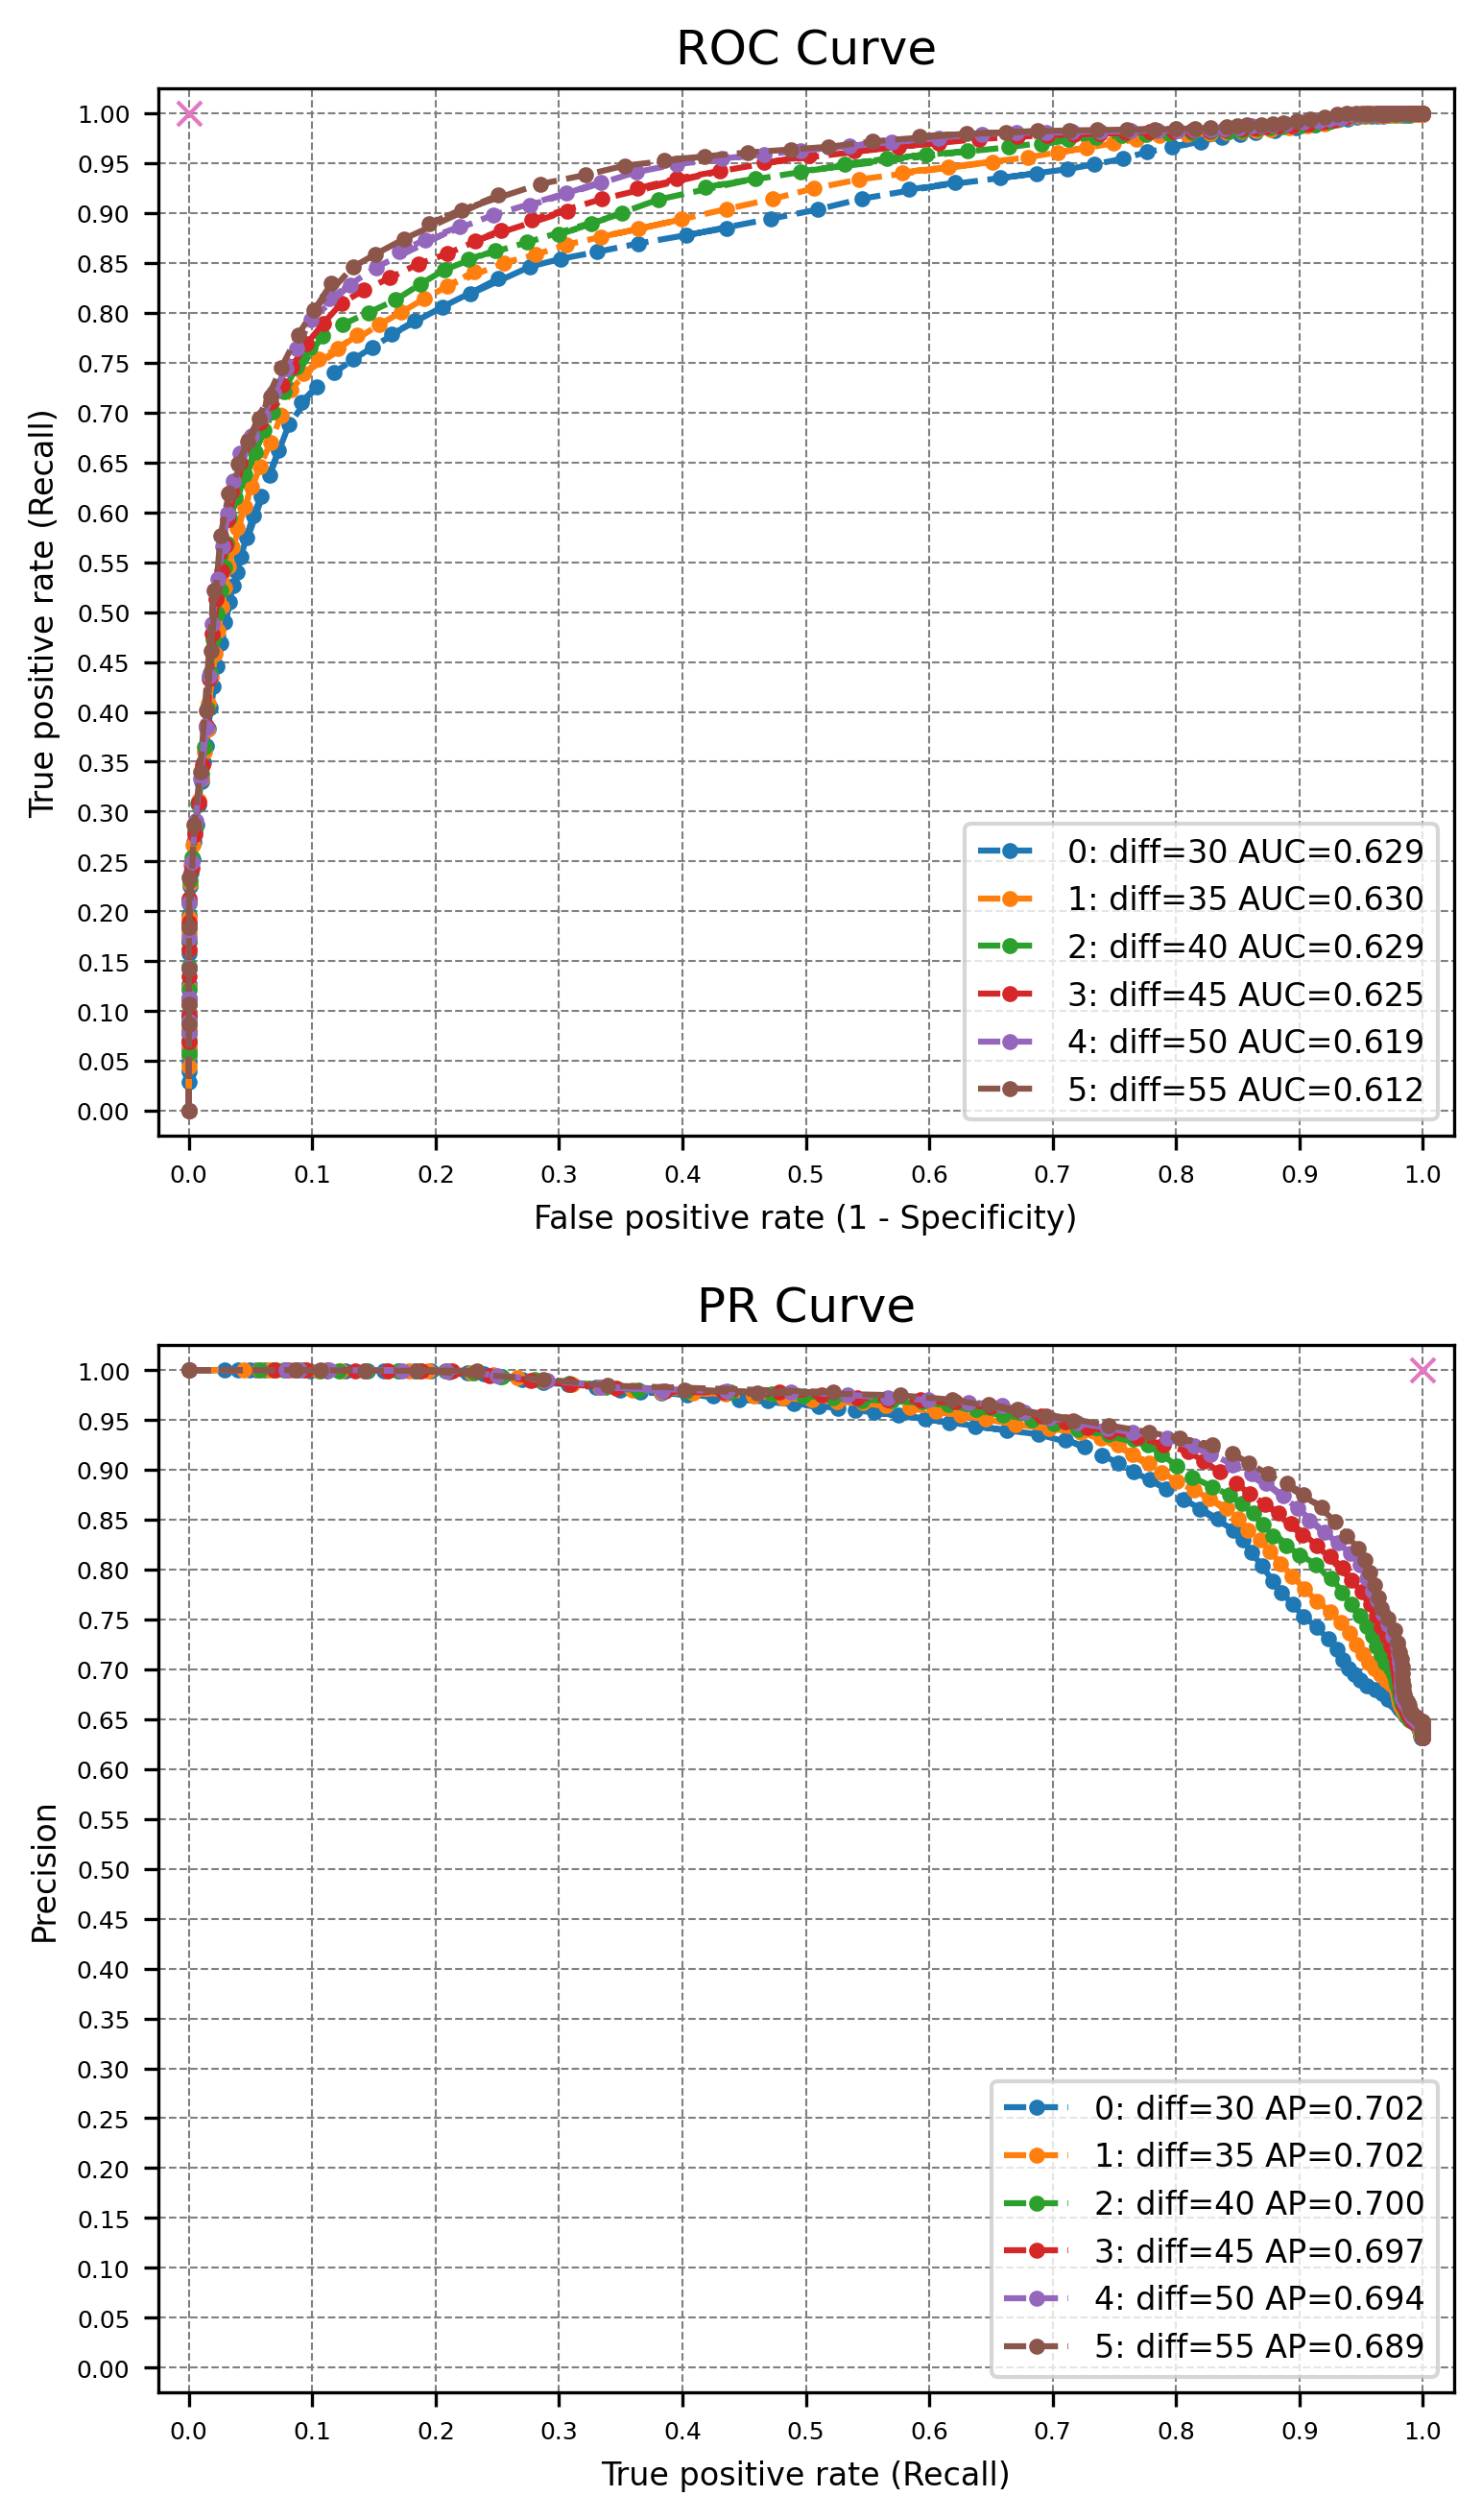

test/diffDetector/metrics_dict_vt_UFPR04_Rainy_training.pickle


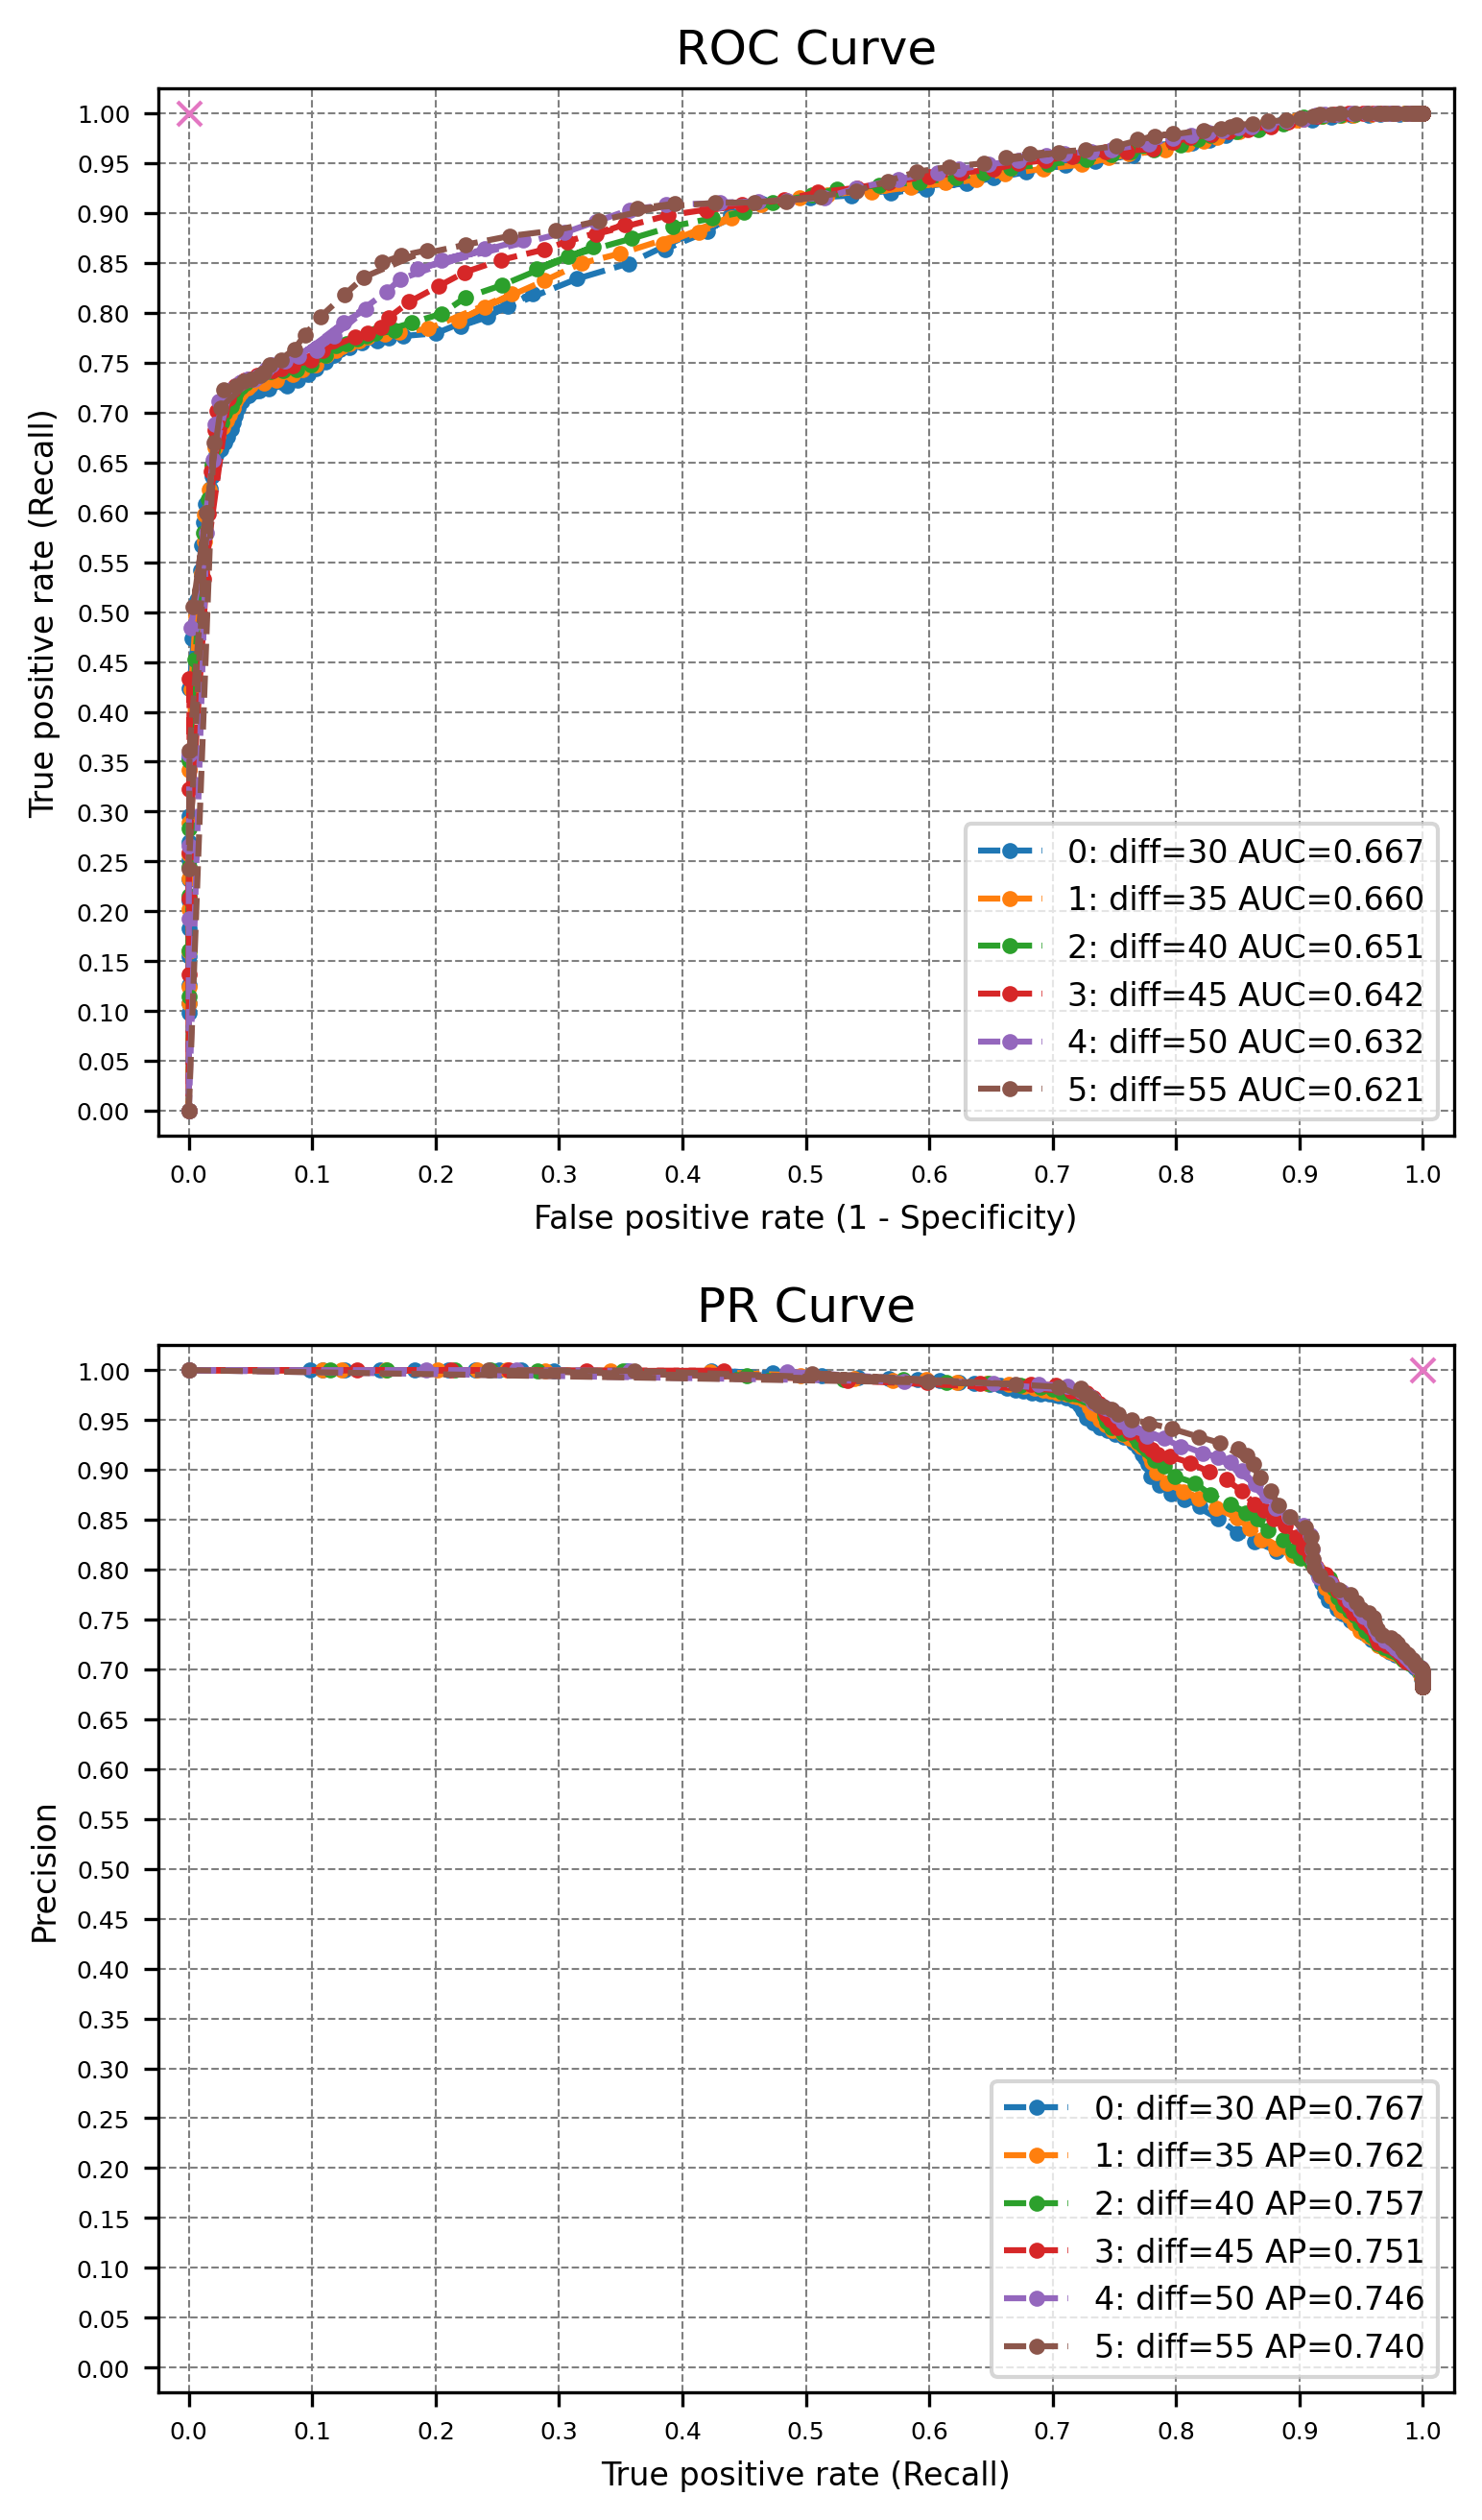

In [5]:
parking_id = 'UFPR04'
training_parking(parking_id)

### UFPR04 Training Choose Parameters

In [2]:
df = choose_training_parameters('UFPR04')

test/diffDetector/metrics_dict_vt_UFPR04_Sunny_training.pickle
test/diffDetector/metrics_dict_vt_UFPR04_Cloudy_training.pickle
test/diffDetector/metrics_dict_vt_UFPR04_Rainy_training.pickle
Training & Sunny & 35 & 0.41 & 0.843 & 0.883 & 0.814 & 0.828 & 0.853
Training & Sunny & 35 & 0.4 & 0.858 & 0.897 & 0.805 & 0.831 & 0.857
Training & Cloudy & 35 & 0.41 & 0.898 & 0.846 & 0.788 & 0.839 & 0.809
Training & Cloudy & 35 & 0.45 & 0.862 & 0.769 & 0.841 & 0.851 & 0.815
Training & Rainy & 30 & 0.41 & 0.931 & 0.878 & 0.763 & 0.839 & 0.799
Training & Rainy & 30 & 0.45 & 0.911 & 0.838 & 0.775 & 0.838 & 0.795


Weather  diff    vt    AUC Dist Curve   Dist  Precision  Specificity  \
0   Sunny    35  0.41  0.652        ROC  0.220      0.843        0.883   
1   Sunny    35  0.40  0.652         PR  0.241      0.858        0.897   
2  Cloudy    35  0.41  0.630        ROC  0.220      0.898        0.846   
3  Cloudy    35  0.45  0.630         PR  0.210      0.862        0.769   
4   Rainy    30  0.41  0.667        ROC  0.220      0.931        0.878   
5   Rainy    30  0.45  0.667         PR  0.210      0.911        0.838   

   Recall     F1  Accuracy  
0   0.814  0.828     0.853  
1   0.805  0.831     0.857  
2   0.788  0.839     0.809  
3   0.841  0.851     0.815  
4   0.763  0.839     0.799  
5   0.775  0.838     0.795

Mejor fila por weather:
  Weather  diff    vt    AUC Dist Curve   Dist  Precision  Specificity  \
3  Cloudy    35  0.45  0.630         PR  0.210      0.862        0.769   
4   Rainy    30  0.41  0.667        ROC  0.220      0.931        0.878   
1   Sunny    35  0.40  0.652         PR  0.241      0.858        0.897   

   Recall     F1  Accuracy  
3   0.841  0.851     0.815  
4   0.763  0.839     0.799  
1   0.805  0.831     0.857  

Mejor fila global:
Weather        Cloudy
diff               35
vt               0.45
AUC              0.63
Dist Curve         PR
Dist             0.21
Precision       0.862
Specificity     0.769
Recall          0.841
F1              0.851
Accuracy        0.815
Name: 3, dtype: object


### UFPR04 Testing

Sunny-Testing bs=35 vt=0.45
Using OccupancyDetectorDiff
Selected 429 files
Processing 429 files with 10 workers


100%|██████████| 429/429 [00:14<00:00, 29.04it/s]


Precision: 0.783
specificity: 0.762
Recall: 0.871
F1 Score: 0.824
Accuracy: 0.816


Test & Sunny & 35 & 0.45 & 0.783 & 0.762 & 0.871 & 0.824 & 0.816
Cloudy-Testing bs=35 vt=0.45
Using OccupancyDetectorDiff
Selected 288 files
Processing 288 files with 10 workers


100%|██████████| 288/288 [00:10<00:00, 28.14it/s]

Precision: 0.901
specificity: 0.784
Recall: 0.839
F1 Score: 0.869
Accuracy: 0.822


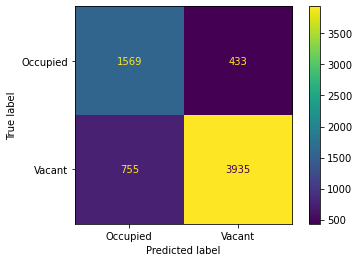

Test & Cloudy & 35 & 0.45 & 0.901 & 0.784 & 0.839 & 0.869 & 0.822
Rainy-Testing bs=35 vt=0.45
Using OccupancyDetectorDiff
Selected 61 files
Processing 61 files with 10 workers


100%|██████████| 61/61 [00:04<00:00, 14.57it/s]

Precision: 0.776
specificity: 0.672
Recall: 0.861
F1 Score: 0.816
Accuracy: 0.780


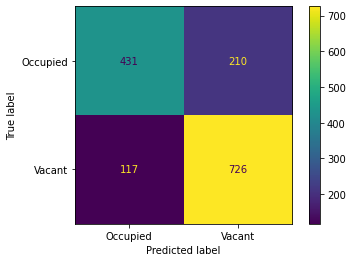

Test & Rainy & 35 & 0.45 & 0.776 & 0.672 & 0.861 & 0.816 & 0.780


In [5]:
test_parking_diff_vt('UFPR04',diff_threshold=35 ,vacant_threshold=0.45)

## UFPR05

### UPFR05 Training

Testing  Training UFPR05-Sunny diff=30
Using OccupancyDetectorDiff
Selected 1989 files
Processing 1989 files with 10 workers


100%|██████████| 1989/1989 [00:57<00:00, 34.30it/s]


Testing  Training UFPR05-Sunny diff=35
Using OccupancyDetectorDiff
Selected 1989 files
Processing 1989 files with 10 workers


100%|██████████| 1989/1989 [00:58<00:00, 34.02it/s]


Testing  Training UFPR05-Sunny diff=40
Using OccupancyDetectorDiff
Selected 1989 files
Processing 1989 files with 10 workers


100%|██████████| 1989/1989 [00:58<00:00, 33.94it/s]


Testing  Training UFPR05-Sunny diff=45
Using OccupancyDetectorDiff
Selected 1989 files
Processing 1989 files with 10 workers


100%|██████████| 1989/1989 [00:58<00:00, 33.96it/s]


Testing  Training UFPR05-Sunny diff=50
Using OccupancyDetectorDiff
Selected 1989 files
Processing 1989 files with 10 workers


100%|██████████| 1989/1989 [00:58<00:00, 34.00it/s]


Testing  Training UFPR05-Sunny diff=55
Using OccupancyDetectorDiff
Selected 1989 files
Processing 1989 files with 10 workers


100%|██████████| 1989/1989 [00:58<00:00, 33.84it/s]


Testing  Training UFPR05-Cloudy diff=30
Using OccupancyDetectorDiff
Selected 1133 files
Processing 1133 files with 10 workers


100%|██████████| 1133/1133 [00:34<00:00, 32.79it/s]


Testing  Training UFPR05-Cloudy diff=35
Using OccupancyDetectorDiff
Selected 1133 files
Processing 1133 files with 10 workers


100%|██████████| 1133/1133 [00:34<00:00, 32.50it/s]


Testing  Training UFPR05-Cloudy diff=40
Using OccupancyDetectorDiff
Selected 1133 files
Processing 1133 files with 10 workers


100%|██████████| 1133/1133 [00:34<00:00, 32.51it/s]


Testing  Training UFPR05-Cloudy diff=45
Using OccupancyDetectorDiff
Selected 1133 files
Processing 1133 files with 10 workers


100%|██████████| 1133/1133 [00:34<00:00, 32.75it/s]


Testing  Training UFPR05-Cloudy diff=50
Using OccupancyDetectorDiff
Selected 1133 files
Processing 1133 files with 10 workers


100%|██████████| 1133/1133 [00:34<00:00, 32.75it/s]


Testing  Training UFPR05-Cloudy diff=55
Using OccupancyDetectorDiff
Selected 1133 files
Processing 1133 files with 10 workers


100%|██████████| 1133/1133 [00:34<00:00, 32.67it/s]


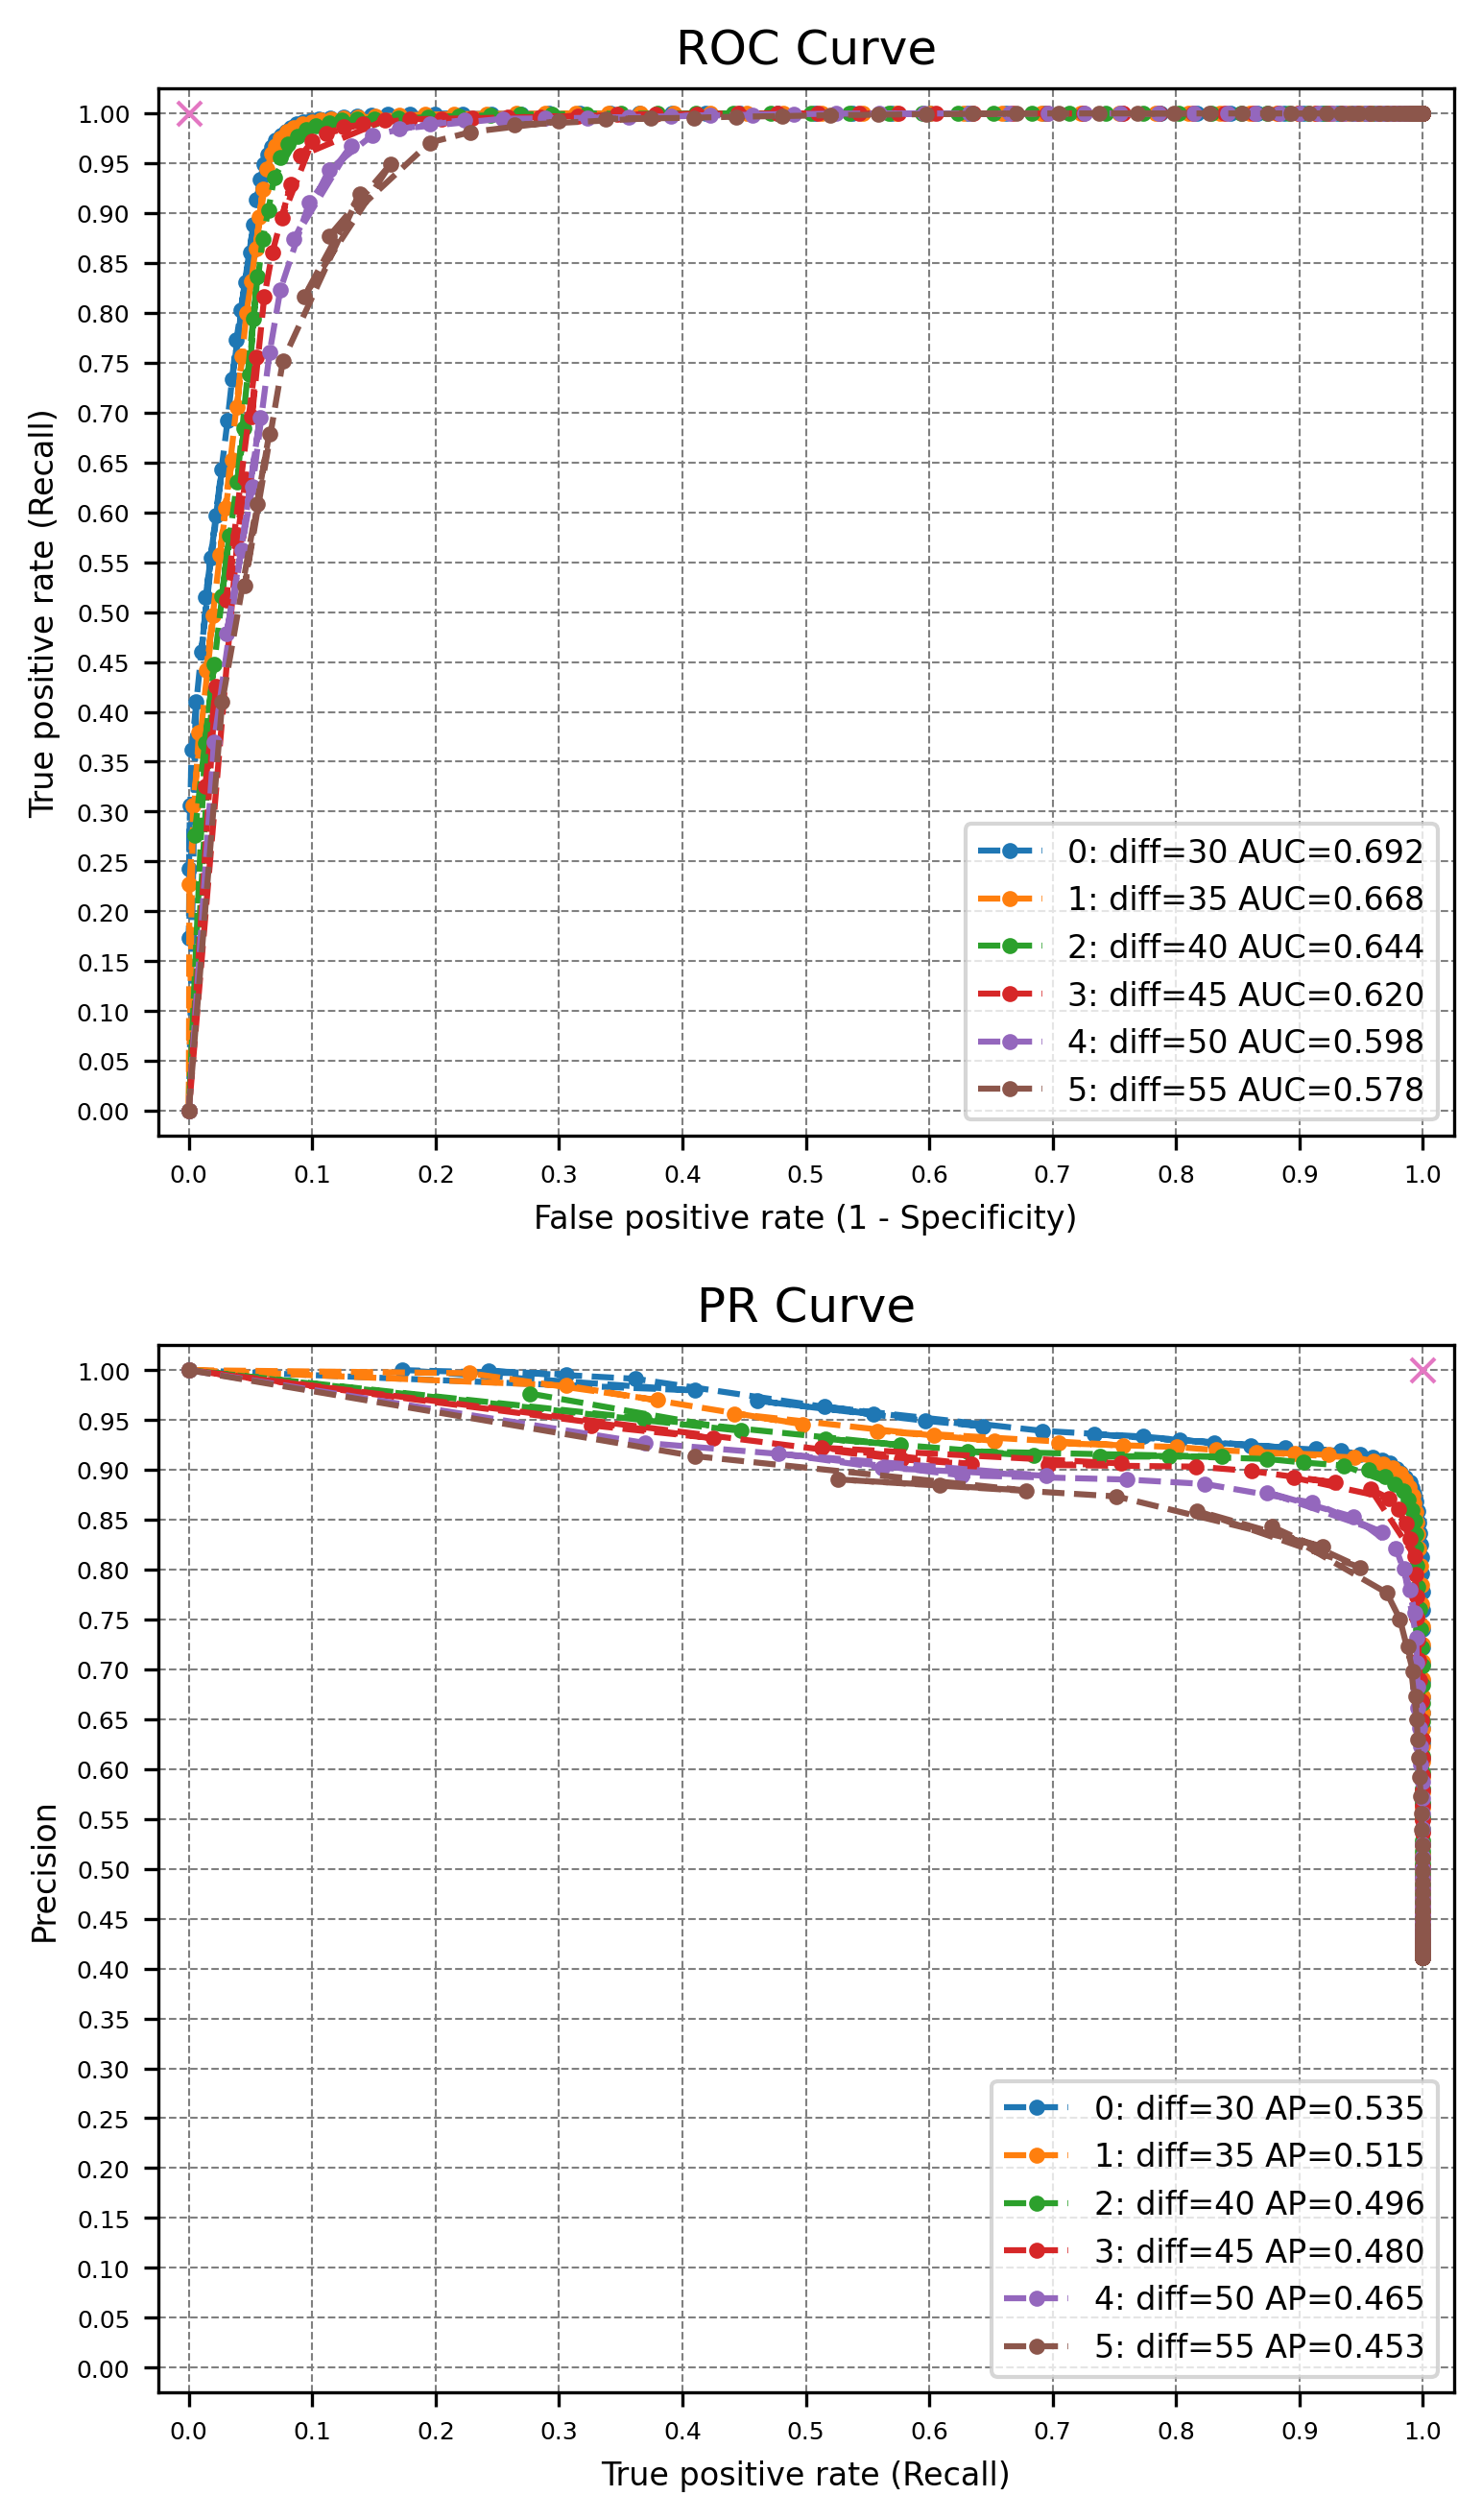

Testing  Training UFPR05-Rainy diff=30
Using OccupancyDetectorDiff
Selected 177 files
Processing 177 files with 10 workers


100%|██████████| 177/177 [00:07<00:00, 24.39it/s]


Testing  Training UFPR05-Rainy diff=35
Using OccupancyDetectorDiff
Selected 177 files
Processing 177 files with 10 workers


100%|██████████| 177/177 [00:07<00:00, 24.16it/s]


Testing  Training UFPR05-Rainy diff=40
Using OccupancyDetectorDiff
Selected 177 files
Processing 177 files with 10 workers


100%|██████████| 177/177 [00:07<00:00, 24.32it/s]


Testing  Training UFPR05-Rainy diff=45
Using OccupancyDetectorDiff
Selected 177 files
Processing 177 files with 10 workers


100%|██████████| 177/177 [00:07<00:00, 24.38it/s]


Testing  Training UFPR05-Rainy diff=50
Using OccupancyDetectorDiff
Selected 177 files
Processing 177 files with 10 workers


100%|██████████| 177/177 [00:07<00:00, 23.98it/s]


Testing  Training UFPR05-Rainy diff=55
Using OccupancyDetectorDiff
Selected 177 files
Processing 177 files with 10 workers


100%|██████████| 177/177 [00:07<00:00, 24.10it/s]


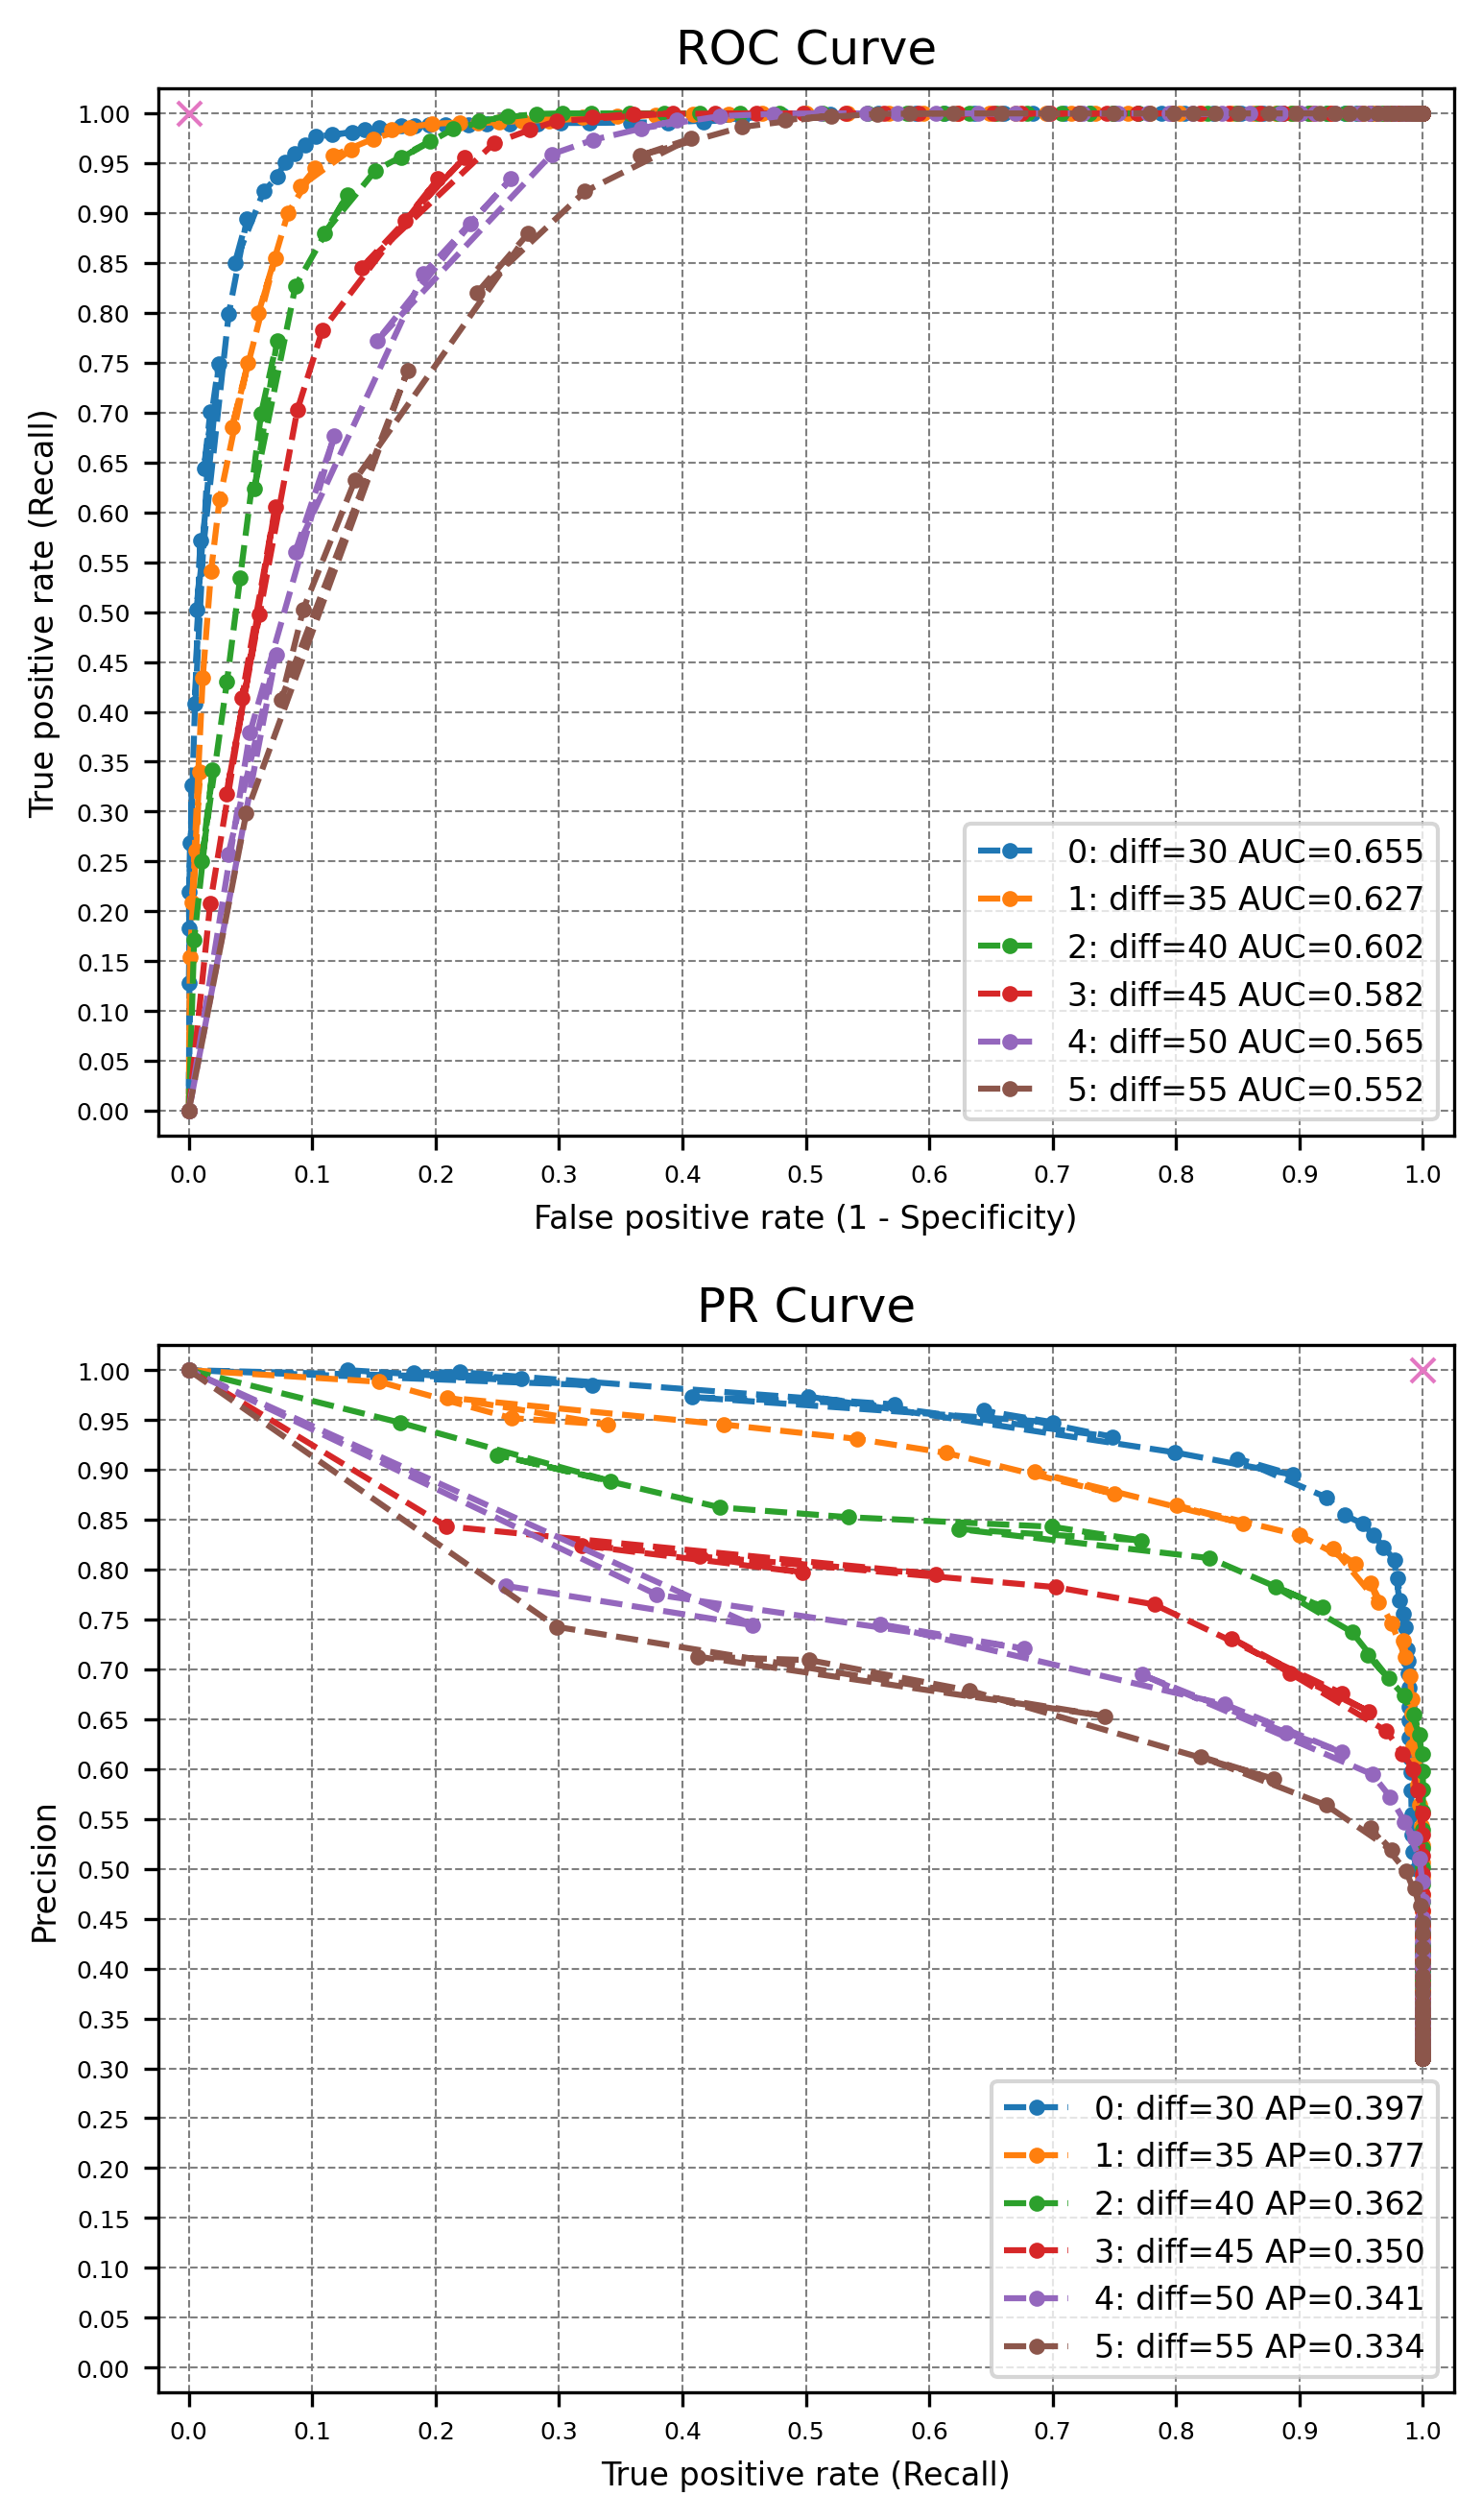

In [4]:
parking_id = 'UFPR05'
training_parking(parking_id)

### UFPR05 Training Choose Parameters

In [3]:
parking_id = 'UFPR05'
choose_training_parameters(parking_id)

test/diffDetector/metrics_dict_vt_UFPR05_Sunny_training.pickle
test/diffDetector/metrics_dict_vt_UFPR05_Cloudy_training.pickle
test/diffDetector/metrics_dict_vt_UFPR05_Rainy_training.pickle
Training & Sunny & 30 & 0.4 & 0.918 & 0.940 & 0.892 & 0.905 & 0.920
Training & Sunny & 30 & 0.37 & 0.946 & 0.962 & 0.879 & 0.911 & 0.927
Training & Cloudy & 30 & 0.22 & 0.910 & 0.933 & 0.967 & 0.938 & 0.947
Training & Cloudy & 30 & 0.22 & 0.910 & 0.933 & 0.967 & 0.938 & 0.947
Training & Rainy & 30 & 0.22 & 0.769 & 0.867 & 0.981 & 0.862 & 0.903
Training & Rainy & 30 & 0.22 & 0.769 & 0.867 & 0.981 & 0.862 & 0.903


Weather  diff    vt    AUC Dist Curve   Dist  Precision  Specificity  \
0   Sunny    30  0.40  0.687        ROC  0.123      0.918        0.940   
1   Sunny    30  0.37  0.687         PR  0.133      0.946        0.962   
2  Cloudy    30  0.22  0.692        ROC  0.075      0.910        0.933   
3  Cloudy    30  0.22  0.692         PR  0.096      0.910        0.933   
4   Rainy    30  0.22  0.655        ROC  0.075      0.769        0.867   
5   Rainy    30  0.22  0.655         PR  0.096      0.769        0.867   

   Recall     F1  Accuracy  
0   0.892  0.905     0.920  
1   0.879  0.911     0.927  
2   0.967  0.938     0.947  
3   0.967  0.938     0.947  
4   0.981  0.862     0.903  
5   0.981  0.862     0.903

Mejor fila por weather:
  Weather  diff    vt    AUC Dist Curve   Dist  Precision  Specificity  \
2  Cloudy    30  0.22  0.692        ROC  0.075      0.910        0.933   
4   Rainy    30  0.22  0.655        ROC  0.075      0.769        0.867   
1   Sunny    30  0.37  0.687         PR  0.133      0.946        0.962   

   Recall     F1  Accuracy  
2   0.967  0.938     0.947  
4   0.981  0.862     0.903  
1   0.879  0.911     0.927  

Mejor fila global:
Weather        Cloudy
diff               30
vt               0.22
AUC             0.692
Dist Curve        ROC
Dist            0.075
Precision        0.91
Specificity     0.933
Recall          0.967
F1              0.938
Accuracy        0.947
Name: 2, dtype: object


Weather  diff    vt    AUC Dist Curve   Dist  Precision  Specificity  \
0   Sunny    30  0.40  0.687        ROC  0.123      0.918        0.940   
1   Sunny    30  0.37  0.687         PR  0.133      0.946        0.962   
2  Cloudy    30  0.22  0.692        ROC  0.075      0.910        0.933   
3  Cloudy    30  0.22  0.692         PR  0.096      0.910        0.933   
4   Rainy    30  0.22  0.655        ROC  0.075      0.769        0.867   
5   Rainy    30  0.22  0.655         PR  0.096      0.769        0.867   

   Recall     F1  Accuracy  
0   0.892  0.905     0.920  
1   0.879  0.911     0.927  
2   0.967  0.938     0.947  
3   0.967  0.938     0.947  
4   0.981  0.862     0.903  
5   0.981  0.862     0.903

### UFPR05 Testing

Sunny-Testing bs=33 vt=0.22
Using OccupancyDetectorDiff
Selected 511 files
Processing 511 files with 10 workers


100%|██████████| 511/511 [00:16<00:00, 30.82it/s]


Precision: 0.999
specificity: 1.000
Recall: 0.685
F1 Score: 0.812
Accuracy: 0.872


Test & Sunny & 33 & 0.22 & 0.999 & 1.000 & 0.685 & 0.812 & 0.872
Cloudy-Testing bs=33 vt=0.22
Using OccupancyDetectorDiff
Selected 293 files
Processing 293 files with 10 workers


100%|██████████| 293/293 [00:10<00:00, 27.98it/s]


Precision: 0.908
specificity: 0.937
Recall: 0.981
F1 Score: 0.943
Accuracy: 0.954


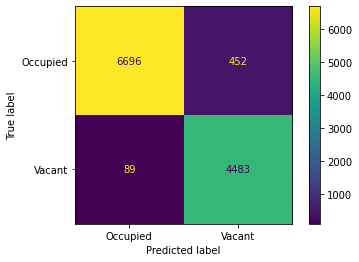

Test & Cloudy & 33 & 0.22 & 0.908 & 0.937 & 0.981 & 0.943 & 0.954
Rainy-Testing bs=33 vt=0.22
Using OccupancyDetectorDiff
Selected 49 files
Processing 49 files with 10 workers


100%|██████████| 49/49 [00:03<00:00, 13.55it/s]

Precision: 0.803
specificity: 0.880
Recall: 0.980
F1 Score: 0.883
Accuracy: 0.913


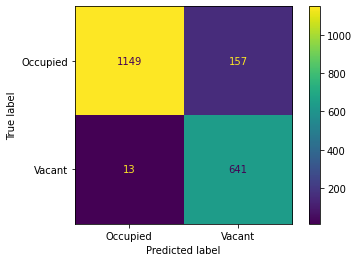

Test & Rainy & 33 & 0.22 & 0.803 & 0.880 & 0.980 & 0.883 & 0.913


In [9]:
parking_id = 'UFPR05'
test_parking_diff_vt(parking_id,diff_threshold=30 ,vacant_threshold=0.22)

## PUCPR

### PUCPR Training

test/diffDetector/metrics_dict_vt_PUCPR_Sunny_training.pickle


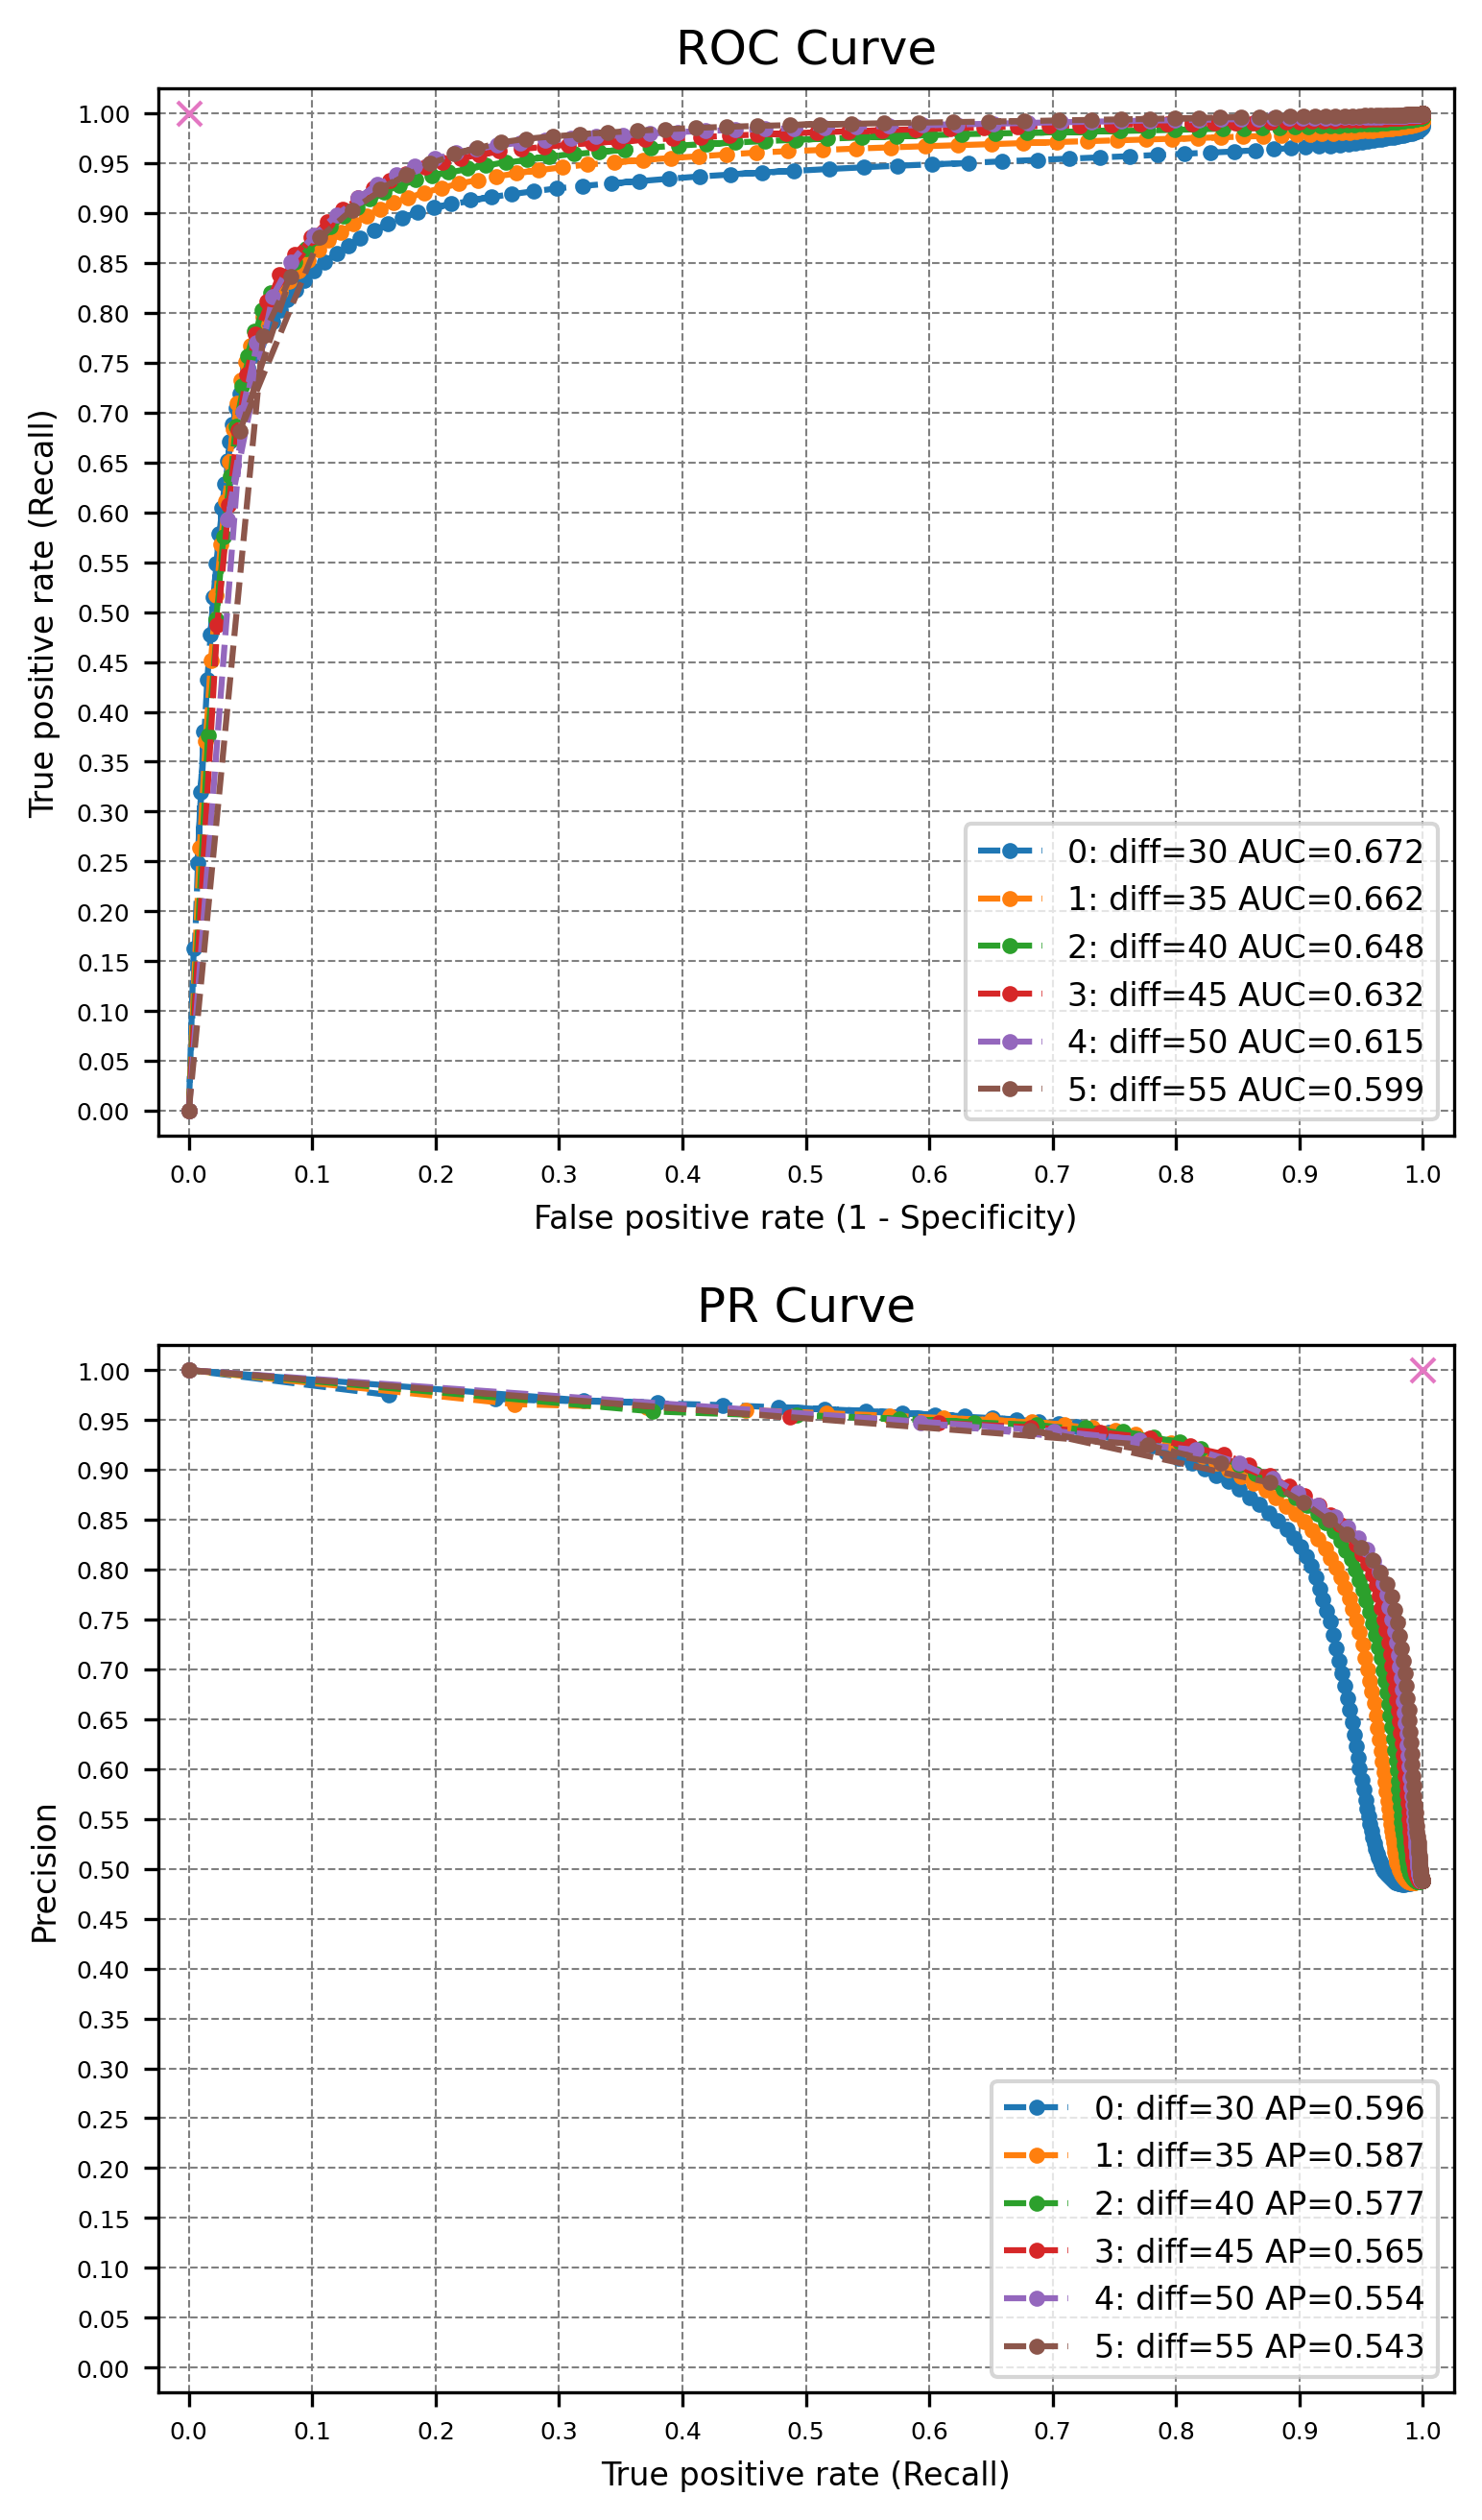

test/diffDetector/metrics_dict_vt_PUCPR_Cloudy_training.pickle


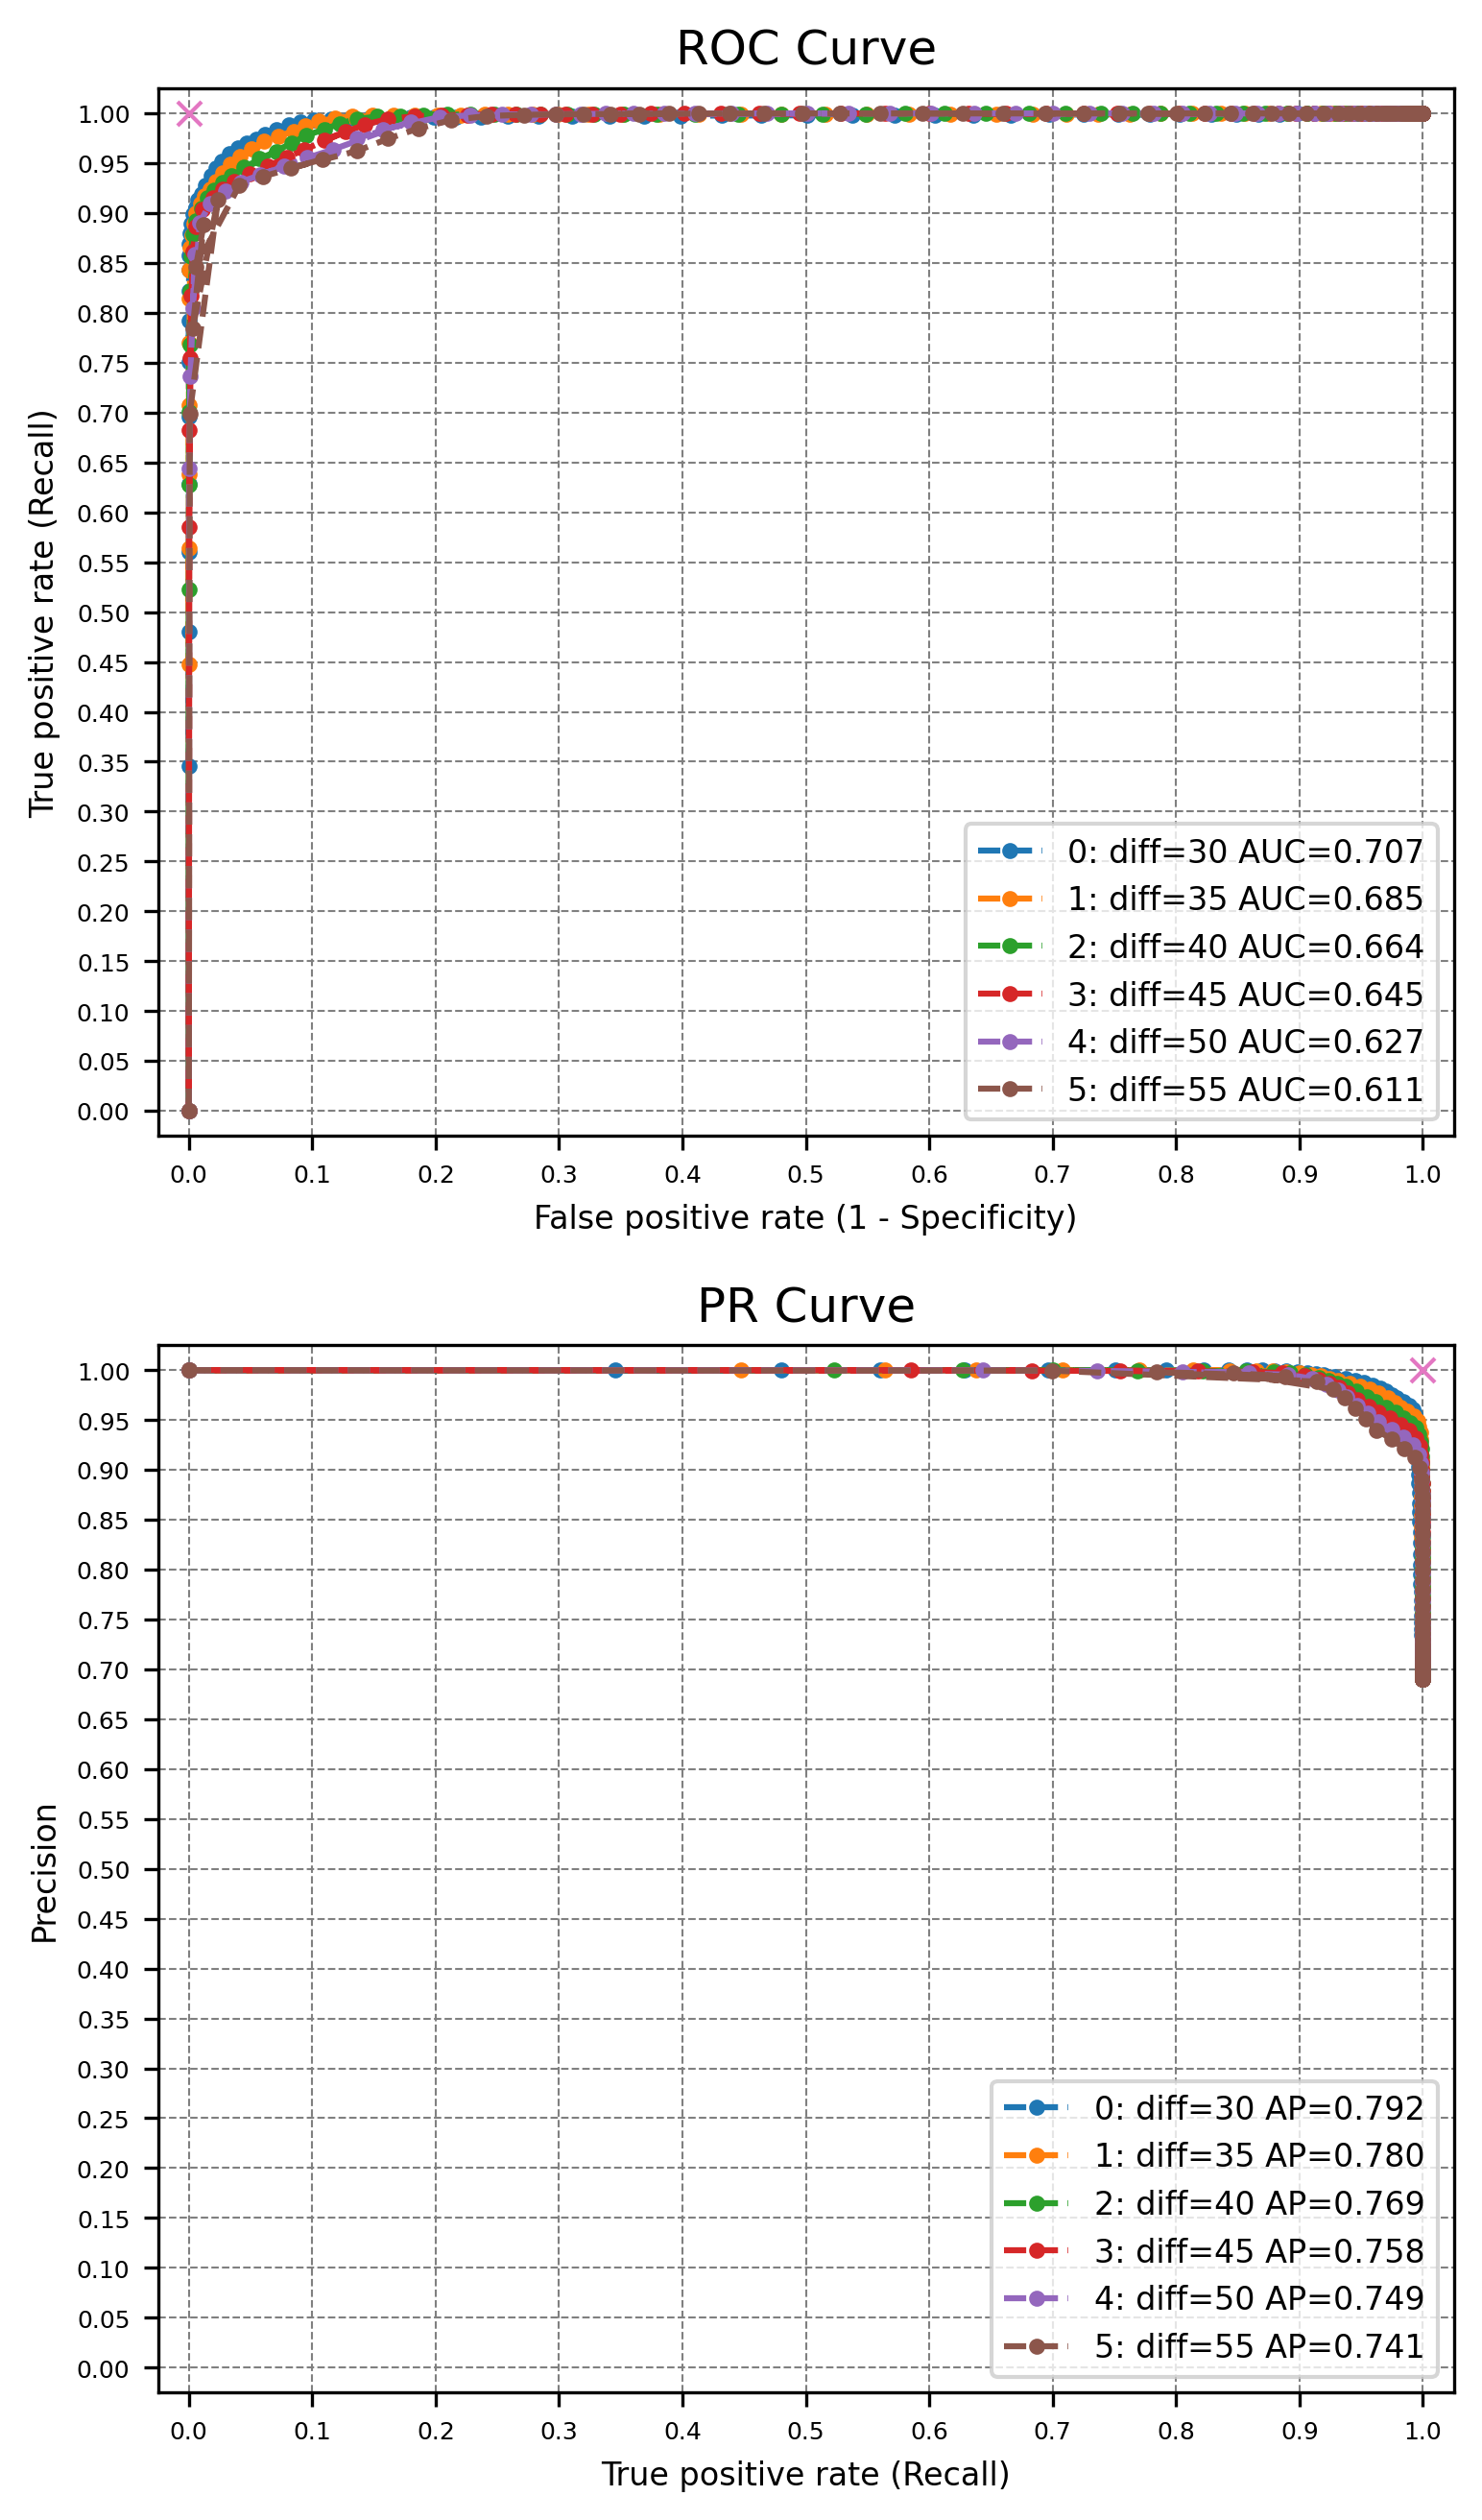

test/diffDetector/metrics_dict_vt_PUCPR_Rainy_training.pickle


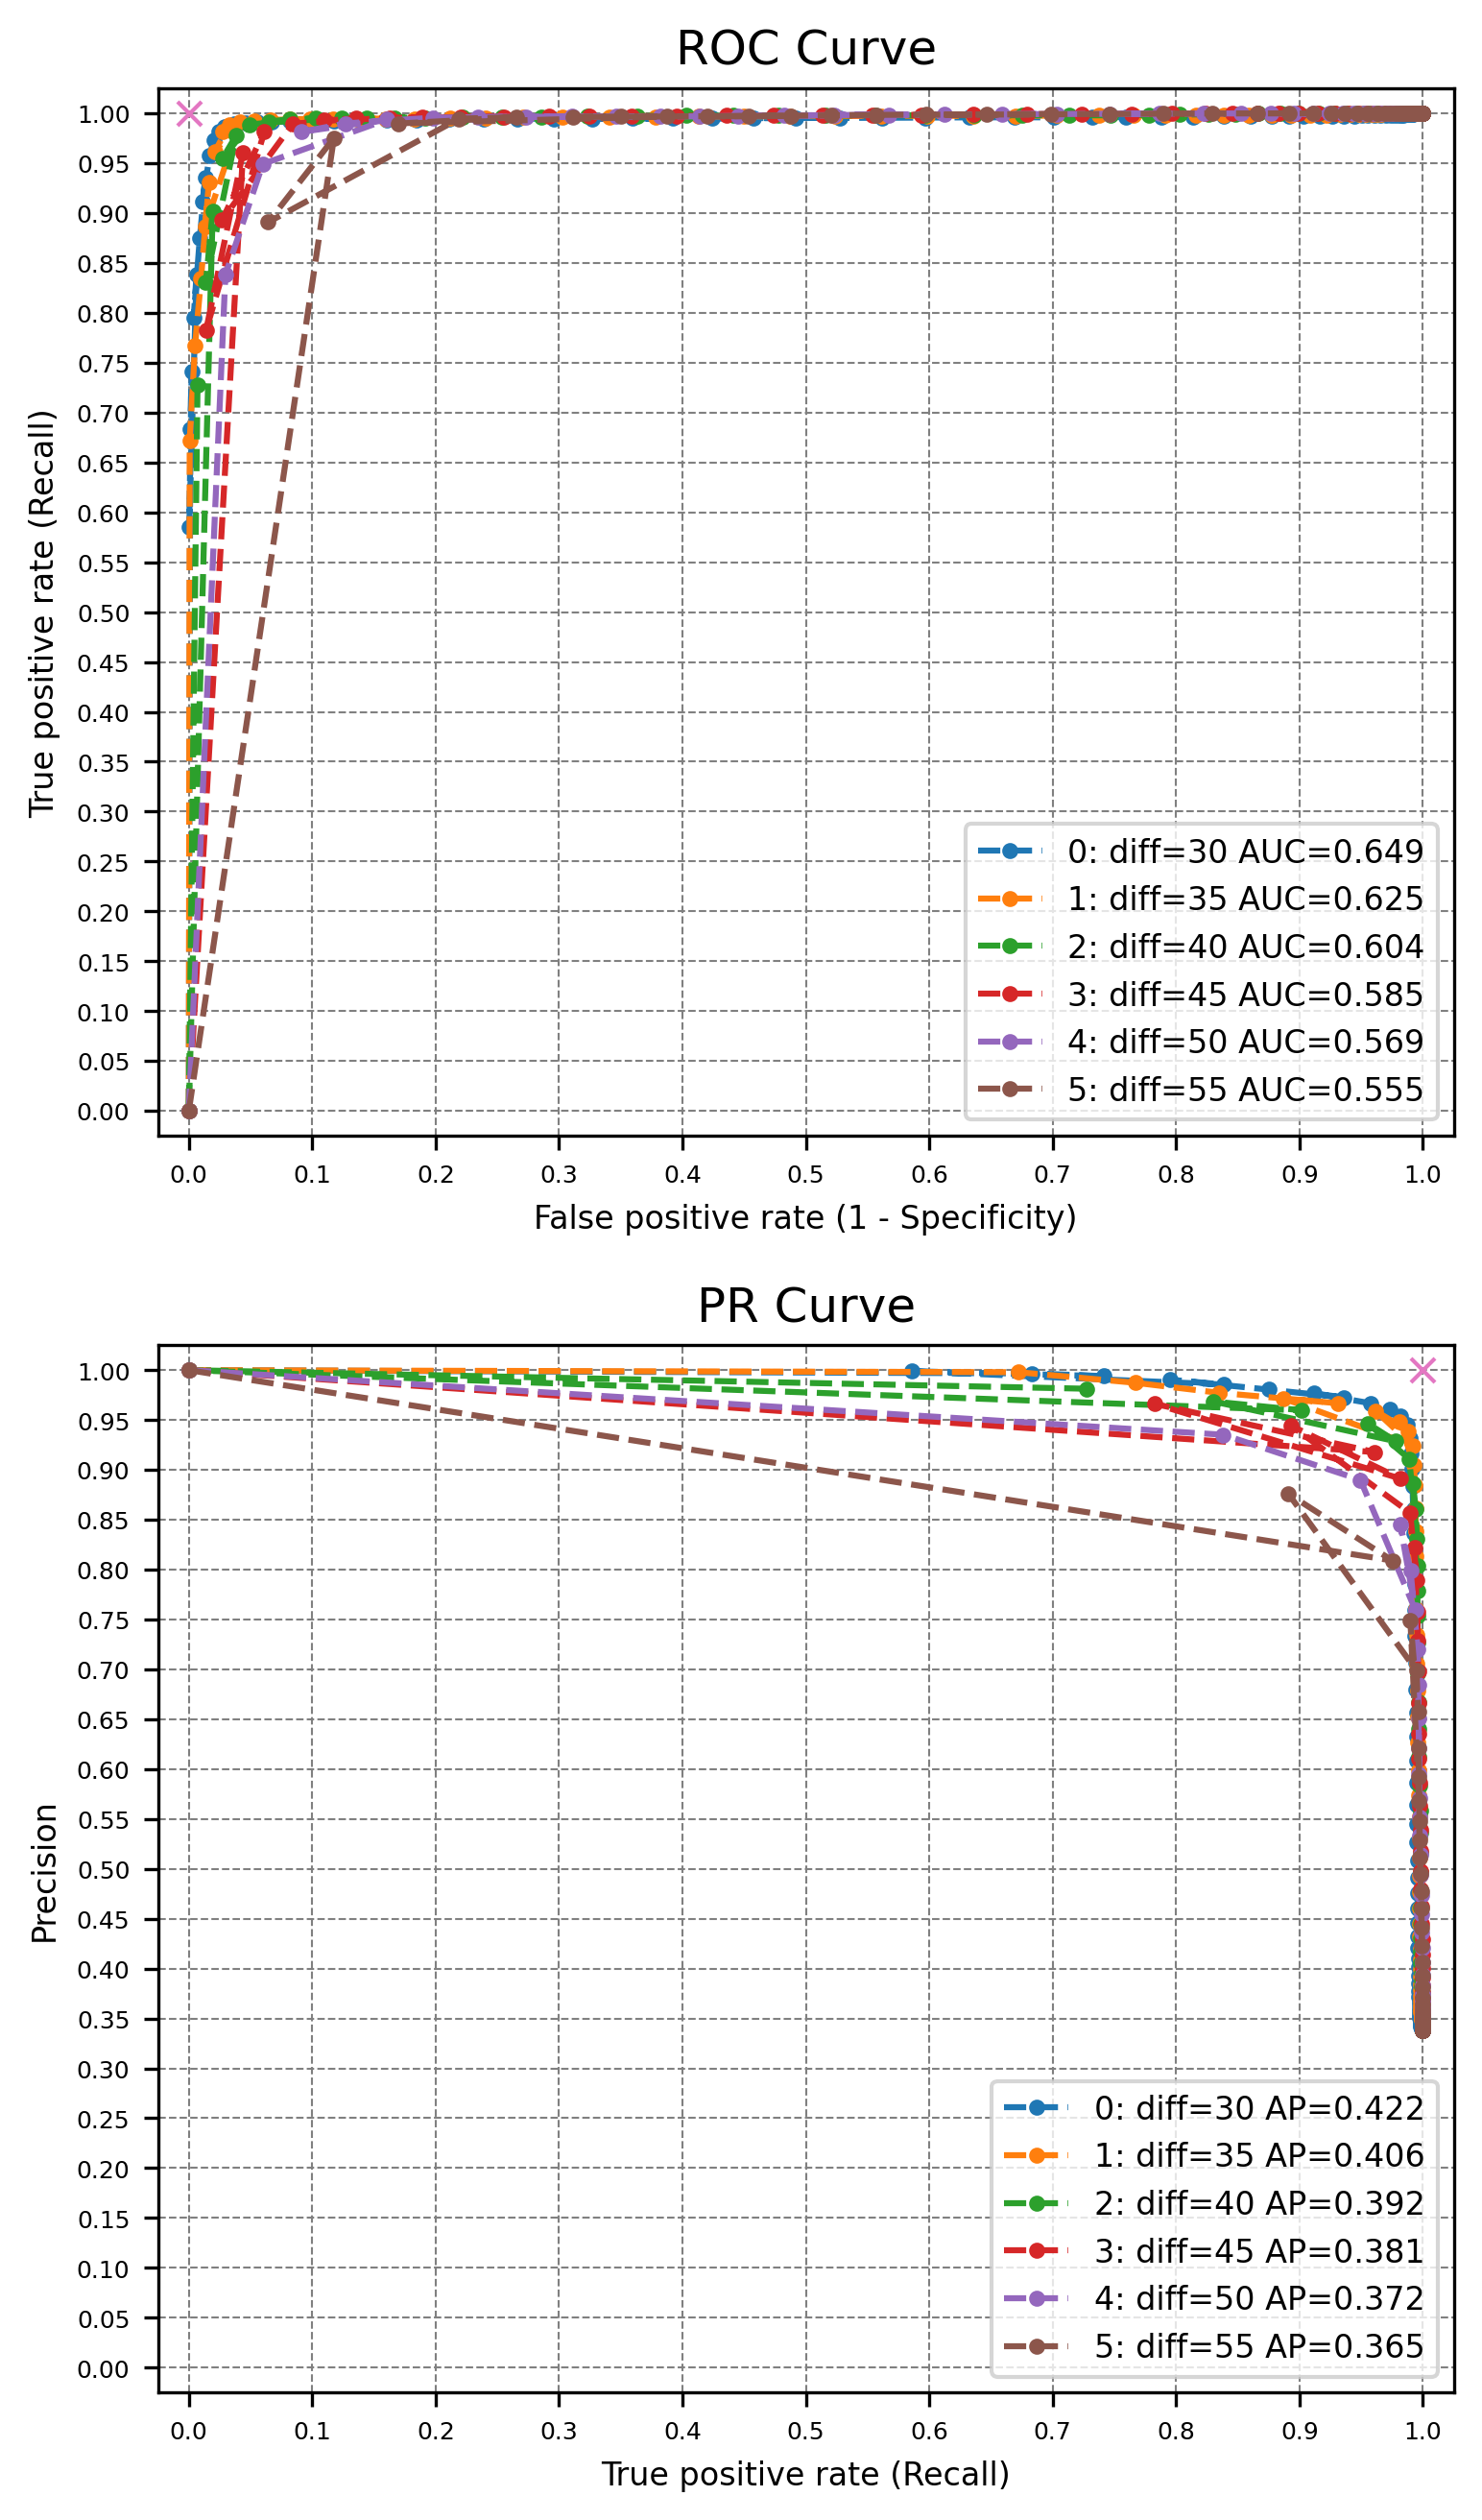

In [2]:
parking_id = 'PUCPR'
training_parking(parking_id)

### PUCPR Training Choose Parameters

In [4]:
parking_id = 'PUCPR'
choose_training_parameters(parking_id)

test/diffDetector/metrics_dict_vt_PUCPR_Sunny_training.pickle
test/diffDetector/metrics_dict_vt_PUCPR_Cloudy_training.pickle
test/diffDetector/metrics_dict_vt_PUCPR_Rainy_training.pickle
Training & Sunny & 30 & 0.29 & 0.872 & 0.880 & 0.860 & 0.866 & 0.870
Training & Sunny & 30 & 0.3 & 0.865 & 0.871 & 0.867 & 0.866 & 0.869
Training & Cloudy & 30 & 0.22 & 0.985 & 0.967 & 0.959 & 0.972 & 0.962
Training & Cloudy & 30 & 0.26 & 0.973 & 0.938 & 0.979 & 0.976 & 0.966
Training & Rainy & 30 & 0.11 & 0.954 & 0.976 & 0.982 & 0.968 & 0.978
Training & Rainy & 30 & 0.26 & 0.632 & 0.704 & 0.995 & 0.773 & 0.803


Weather  diff    vt    AUC Dist Curve   Dist  Precision  Specificity  \
0   Sunny    30  0.29  0.672        ROC  0.185      0.872        0.880   
1   Sunny    30  0.30  0.672         PR  0.189      0.865        0.871   
2  Cloudy    30  0.22  0.707        ROC  0.052      0.985        0.967   
3  Cloudy    30  0.26  0.707         PR  0.035      0.973        0.938   
4   Rainy    30  0.11  0.649        ROC  0.030      0.954        0.976   
5   Rainy    30  0.26  0.649         PR  0.035      0.632        0.704   

   Recall     F1  Accuracy  
0   0.860  0.866     0.870  
1   0.867  0.866     0.869  
2   0.959  0.972     0.962  
3   0.979  0.976     0.966  
4   0.982  0.968     0.978  
5   0.995  0.773     0.803

Mejor fila por weather:
  Weather  diff    vt    AUC Dist Curve   Dist  Precision  Specificity  \
3  Cloudy    30  0.26  0.707         PR  0.035      0.973        0.938   
4   Rainy    30  0.11  0.649        ROC  0.030      0.954        0.976   
0   Sunny    30  0.29  0.672        ROC  0.185      0.872        0.880   

   Recall     F1  Accuracy  
3   0.979  0.976     0.966  
4   0.982  0.968     0.978  
0   0.860  0.866     0.870  

Mejor fila global:
Weather        Cloudy
diff               30
vt               0.26
AUC             0.707
Dist Curve         PR
Dist            0.035
Precision       0.973
Specificity     0.938
Recall          0.979
F1              0.976
Accuracy        0.966
Name: 3, dtype: object


Weather  diff    vt    AUC Dist Curve   Dist  Precision  Specificity  \
0   Sunny    30  0.29  0.672        ROC  0.185      0.872        0.880   
1   Sunny    30  0.30  0.672         PR  0.189      0.865        0.871   
2  Cloudy    30  0.22  0.707        ROC  0.052      0.985        0.967   
3  Cloudy    30  0.26  0.707         PR  0.035      0.973        0.938   
4   Rainy    30  0.11  0.649        ROC  0.030      0.954        0.976   
5   Rainy    30  0.26  0.649         PR  0.035      0.632        0.704   

   Recall     F1  Accuracy  
0   0.860  0.866     0.870  
1   0.867  0.866     0.869  
2   0.959  0.972     0.962  
3   0.979  0.976     0.966  
4   0.982  0.968     0.978  
5   0.995  0.773     0.803

Sunny-Testing bs=33 vt=0.26
Using OccupancyDetectorDiff
Selected 471 files
Processing 471 files with 10 workers


100%|██████████| 471/471 [00:18<00:00, 25.05it/s]


Precision: 0.883
specificity: 0.903
Recall: 0.863
F1 Score: 0.873
Accuracy: 0.885


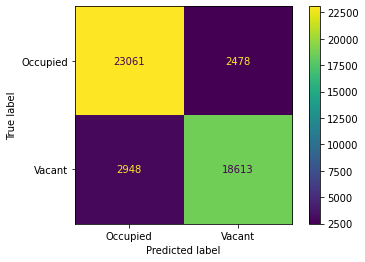

Test & Sunny & 33 & 0.26 & 0.883 & 0.903 & 0.863 & 0.873 & 0.885
Cloudy-Testing bs=33 vt=0.26
Using OccupancyDetectorDiff
Selected 269 files
Processing 269 files with 10 workers


100%|██████████| 269/269 [00:11<00:00, 22.77it/s]


Precision: 0.960
specificity: 0.926
Recall: 0.983
F1 Score: 0.971
Accuracy: 0.963


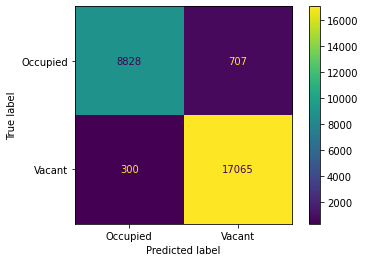

Test & Cloudy & 33 & 0.26 & 0.960 & 0.926 & 0.983 & 0.971 & 0.963
Rainy-Testing bs=33 vt=0.26
Using OccupancyDetectorDiff
Selected 169 files
Processing 169 files with 10 workers


100%|██████████| 169/169 [00:08<00:00, 20.50it/s]

Precision: 0.624
specificity: 0.709
Recall: 0.983
F1 Score: 0.763
Accuracy: 0.799


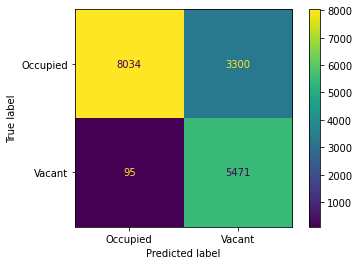

Test & Rainy & 33 & 0.26 & 0.624 & 0.709 & 0.983 & 0.763 & 0.799


In [6]:
parking_id = 'PUCPR'
test_parking_diff_vt(parking_id,diff_threshold=30 ,vacant_threshold=0.26)

Sunny-Testing bs=33 vt=0.4
Using OccupancyDetectorDiff
Selected 511 files
Processing 511 files with 10 workers


100%|██████████| 511/511 [00:19<00:00, 26.67it/s]


Precision: 0.913
specificity: 0.941
Recall: 0.902
F1 Score: 0.907
Accuracy: 0.925


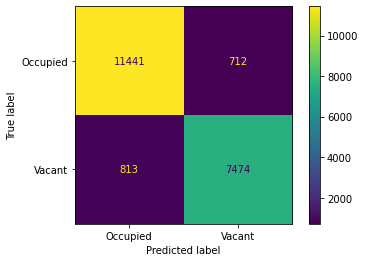

Test & Sunny & 33 & 0.4 & 0.913 & 0.941 & 0.902 & 0.907 & 0.925


In [5]:
parking_id = 'UFPR05'
test_parking_diff_vt(parking_id,diff_threshold=30 ,vacant_threshold=0.40, weather_list=['Sunny'])

### PUCPR Testing

Sunny-Testing bs=33 vt=0.26
Using OccupancyDetectorDiff
Selected 471 files
Processing 471 files with 10 workers


100%|██████████| 471/471 [00:16<00:00, 29.37it/s]


Precision: 0.883
specificity: 0.903
Recall: 0.863
F1 Score: 0.873
Accuracy: 0.885


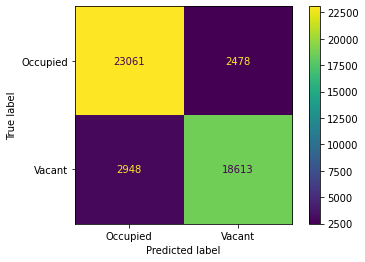

Test & Sunny & 33 & 0.26 & 0.883 & 0.903 & 0.863 & 0.873 & 0.885
Cloudy-Testing bs=33 vt=0.26
Using OccupancyDetectorDiff
Selected 269 files
Processing 269 files with 10 workers


100%|██████████| 269/269 [00:10<00:00, 26.70it/s]


Precision: 0.960
specificity: 0.926
Recall: 0.983
F1 Score: 0.971
Accuracy: 0.963


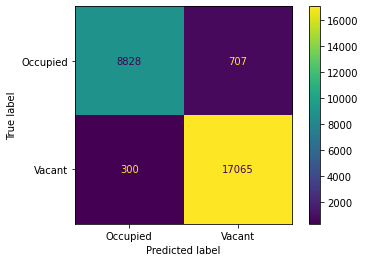

Test & Cloudy & 33 & 0.26 & 0.960 & 0.926 & 0.983 & 0.971 & 0.963
Rainy-Testing bs=33 vt=0.26
Using OccupancyDetectorDiff
Selected 169 files
Processing 169 files with 10 workers


100%|██████████| 169/169 [00:07<00:00, 23.68it/s]

Precision: 0.624
specificity: 0.709
Recall: 0.983
F1 Score: 0.763
Accuracy: 0.799


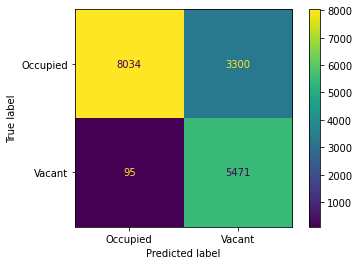

Test & Rainy & 33 & 0.26 & 0.624 & 0.709 & 0.983 & 0.763 & 0.799


In [10]:
parking_id = 'PUCPR'
test_parking_diff_vt(parking_id,diff_threshold=30 ,vacant_threshold=0.26)

In [19]:
training = False
training_str = 'Training' if training else 'Testing'
detection_params=DetectionParams()
detection_params.diff_threshold = 20
detection_params.vacant_threshold = 0.22
detection_params.match_histograms = True
detection_params.show_imshow = True
weather = "Sunny"
parking_id = "UFPR05"


test_parking(parking_id, weather, detection_params=detection_params, process_batch=False, training=training)

    

Using OccupancyDetectorDiff
Selected 511 files


KeyboardInterrupt: 

#### Fine tuning parameters

Sunny-Testing bs=35 vt=0.41
Using OccupancyDetectorDiff
Selected 429 files
Processing 429 files with 10 workers


100%|██████████| 429/429 [00:14<00:00, 29.13it/s]


Precision: 0.840
specificity: 0.841
Recall: 0.844
F1 Score: 0.842
Accuracy: 0.843


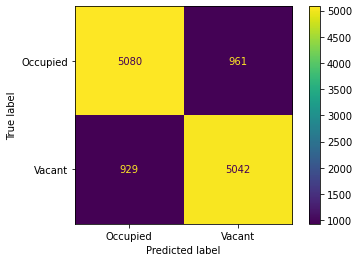

Test & Sunny & 35 & 0.41 & 0.840 & 0.841 & 0.844 & 0.842 & 0.843
Cloudy-Testing bs=35 vt=0.45
Using OccupancyDetectorDiff
Selected 288 files
Processing 288 files with 10 workers


100%|██████████| 288/288 [00:10<00:00, 27.04it/s]


Precision: 0.901
specificity: 0.784
Recall: 0.839
F1 Score: 0.869
Accuracy: 0.822


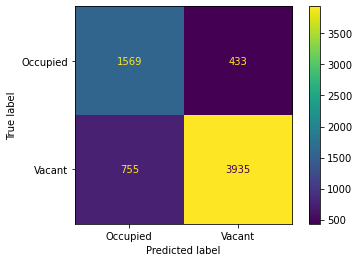

Test & Cloudy & 35 & 0.45 & 0.901 & 0.784 & 0.839 & 0.869 & 0.822
Rainy-Testing bs=30 vt=0.45
Using OccupancyDetectorDiff
Selected 61 files
Processing 61 files with 10 workers


100%|██████████| 61/61 [00:04<00:00, 15.20it/s]


Precision: 0.862
specificity: 0.833
Recall: 0.795
F1 Score: 0.827
Accuracy: 0.811


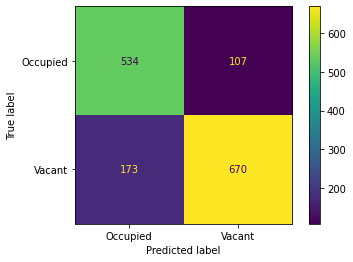

Test & Rainy & 30 & 0.45 & 0.862 & 0.833 & 0.795 & 0.827 & 0.811
Sunny-Testing bs=30 vt=0.4
Using OccupancyDetectorDiff
Selected 511 files
Processing 511 files with 10 workers


100%|██████████| 511/511 [00:16<00:00, 30.76it/s]


Precision: 0.913
specificity: 0.941
Recall: 0.902
F1 Score: 0.907
Accuracy: 0.925


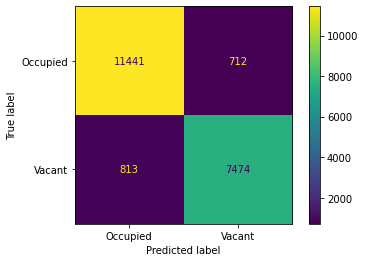

Test & Sunny & 30 & 0.4 & 0.913 & 0.941 & 0.902 & 0.907 & 0.925
Cloudy-Testing bs=30 vt=0.22
Using OccupancyDetectorDiff
Selected 293 files
Processing 293 files with 10 workers


100%|██████████| 293/293 [00:10<00:00, 27.85it/s]


Precision: 0.908
specificity: 0.937
Recall: 0.981
F1 Score: 0.943
Accuracy: 0.954


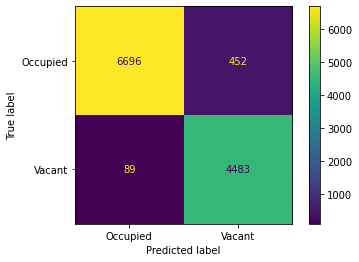

Test & Cloudy & 30 & 0.22 & 0.908 & 0.937 & 0.981 & 0.943 & 0.954
Rainy-Testing bs=30 vt=0.22
Using OccupancyDetectorDiff
Selected 49 files
Processing 49 files with 10 workers


100%|██████████| 49/49 [00:03<00:00, 13.59it/s]

Precision: 0.803
specificity: 0.880
Recall: 0.980
F1 Score: 0.883
Accuracy: 0.913


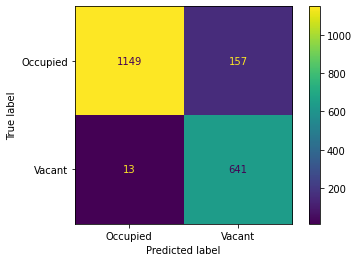

Test & Rainy & 30 & 0.22 & 0.803 & 0.880 & 0.980 & 0.883 & 0.913
Sunny-Testing bs=30 vt=0.29
Using OccupancyDetectorDiff
Selected 471 files
Processing 471 files with 10 workers


100%|██████████| 471/471 [00:16<00:00, 29.29it/s]


Precision: 0.862
specificity: 0.879
Recall: 0.893
F1 Score: 0.877
Accuracy: 0.885


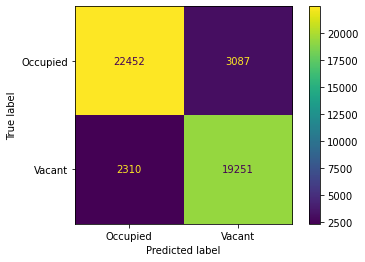

Test & Sunny & 30 & 0.29 & 0.862 & 0.879 & 0.893 & 0.877 & 0.885
Cloudy-Testing bs=30 vt=0.26
Using OccupancyDetectorDiff
Selected 269 files
Processing 269 files with 10 workers


100%|██████████| 269/269 [00:09<00:00, 27.02it/s]


Precision: 0.960
specificity: 0.926
Recall: 0.983
F1 Score: 0.971
Accuracy: 0.963


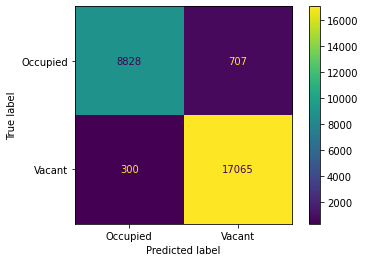

Test & Cloudy & 30 & 0.26 & 0.960 & 0.926 & 0.983 & 0.971 & 0.963
Rainy-Testing bs=30 vt=0.11
Using OccupancyDetectorDiff
Selected 169 files
Processing 169 files with 10 workers


100%|██████████| 169/169 [00:07<00:00, 23.63it/s]

Precision: 0.937
specificity: 0.968
Recall: 0.965
F1 Score: 0.951
Accuracy: 0.967


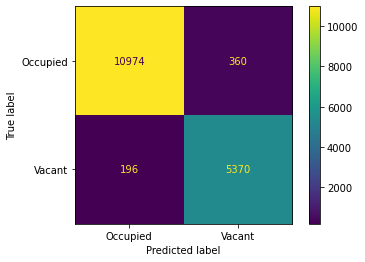

Test & Rainy & 30 & 0.11 & 0.937 & 0.968 & 0.965 & 0.951 & 0.967


In [6]:
test_parking_diff_vt('UFPR04',diff_threshold=35 ,vacant_threshold=0.41, weather_list=['Sunny'])
test_parking_diff_vt('UFPR04',diff_threshold=35 ,vacant_threshold=0.45, weather_list=['Cloudy'])
test_parking_diff_vt('UFPR04',diff_threshold=30 ,vacant_threshold=0.45, weather_list=['Rainy'])

test_parking_diff_vt('UFPR05',diff_threshold=30 ,vacant_threshold=0.40, weather_list=['Sunny'])
test_parking_diff_vt('UFPR05',diff_threshold=30 ,vacant_threshold=0.22, weather_list=['Cloudy'])
test_parking_diff_vt('UFPR05',diff_threshold=30 ,vacant_threshold=0.22, weather_list=['Rainy'])

test_parking_diff_vt('PUCPR',diff_threshold=30 ,vacant_threshold=0.29, weather_list=['Sunny'])
test_parking_diff_vt('PUCPR',diff_threshold=30 ,vacant_threshold=0.26, weather_list=['Cloudy'])
test_parking_diff_vt('PUCPR',diff_threshold=30 ,vacant_threshold=0.11, weather_list=['Rainy'])


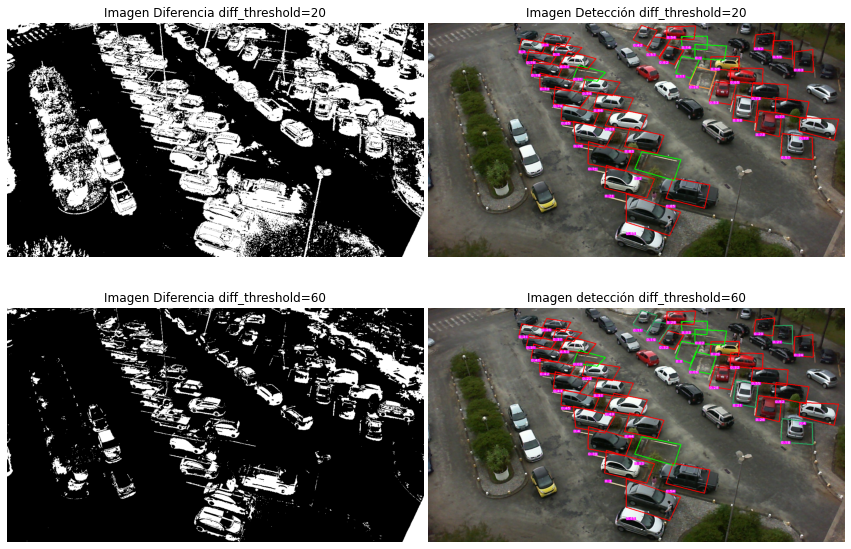

In [ ]:
import matplotlib.pyplot as plt
import cv2

fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

plt.subplots_adjust(wspace=0.01, hspace=0.1)

ax1.imshow(cv2.cvtColor(cv2.imread('img_diff_threshold_20.png'), cv2.COLOR_BGR2RGB))
ax1.set_title('Imagen Diferencia diff_threshold=20', fontsize=12)
ax1.axis('off')

ax2.imshow(cv2.cvtColor(cv2.imread('img_detection_20.png'), cv2.COLOR_BGR2RGB))
ax2.set_title('Imagen Detección diff_threshold=20', fontsize=12)
ax2.axis('off')

ax3.imshow(cv2.imread('img_diff_threshold_60.png'))
ax3.set_title('Imagen Diferencia diff_threshold=60', fontsize=12)
ax3.axis('off')

ax4.imshow(cv2.cvtColor(cv2.imread('img_detection_60.png'), cv2.COLOR_BGR2RGB))
ax4.set_title('Imagen detección diff_threshold=60', fontsize=12)
ax4.axis('off')

plt.show()
